# 0.0 - Imports

In [2]:
import math
import numpy as np
import pandas as pd
import inflection
import datetime
import seaborn as sns

from boruta import BorutaPy
from scipy import stats as ss
from matplotlib import pyplot as plt
from IPython.core.display import HTML

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from matplotlib.gridspec import GridSpec
from tabulate import tabulate



## 0.1 - Helper Functions

In [3]:
def jupyter_settings():
    plt.style.use("bmh")
    plt.rcParams["figure.figsize"] = [25, 12]
    plt.rcParams["font.size"] = 24

    display(HTML("<style>.container { width:100% !important; }</style>"))
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = 50
    pd.set_option("display.expand_frame_repr", False)

    sns.set()

    return None

In [4]:
jupyter_settings()

In [5]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [6]:
def rename_cols(dataframe):
    #Rename columns
    cols_old = list(dataframe)
    # Function from rename
    snakecase = lambda x: inflection.underscore(x)
    cols_new = list(map(snakecase, cols_old))
    # Renaming columns
    dataframe.columns = cols_new
    

    return dataframe

def fillout_na(dataframe):
    # Fillout Na's
    dfataframe["competition_distance"] = dataframe["competition_distance"].apply(
        lambda x: 200000.0 if math.isnan(x) else x
    )
    # competition_open_since_month
    dataframe["competition_open_since_month"] = dataframe.apply(
        lambda x: x["date"].month
        if math.isnan(x["competition_open_since_month"])
        else x["competition_open_since_month"],
        axis=1,
    )
    # competition_open_since_year
    dataframe["competition_open_since_year"] = dataframe.apply(
        lambda x: x["date"].year
        if math.isnan(x["competition_open_since_year"])
        else x["competition_open_since_year"],
        axis=1,
    )
    # promo2_since_week
    dataframe["promo2_since_week"] = dataframe.apply(
        lambda x: x["date"].week
        if math.isnan(x["promo2_since_week"])
        else x["promo2_since_week"],
        axis=1,
    )
    # promo2_since_year
    dataframe["promo2_since_year"] = dataframe.apply(
        lambda x: x["date"].year
        if math.isnan(x["promo2_since_year"])
        else x["promo2_since_year"],
        axis=1,
    )
    # promo_interval
    month_map = {
        1: "Jan",
        2: "Fev",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec",
    }
    dataframe["promo_interval"].fillna(0, inplace=True)
    dataframe["month_map"] = df1["date"].dt.month.map(month_map)
    dataframe["is_promo"] = df1[["promo_interval", "month_map"]].apply(
        lambda x: 0
        if x["promo_interval"] == 0
        else 1
        if x["month_map"] in x["promo_interval"].split(",")
        else 0,
        axis=1,
    )
    return dataframe

def change_types(dataframe):
    dataframe["competition_open_since_month"] = dataframe["competition_open_since_month"].astype(int)
    dataframe["competition_open_since_year"] = dataframe["competition_open_since_year"].astype(int)
    dataframe["promo2_since_week"] = dataframe["promo2_since_week"].astype(int)
    dataframe["promo2_since_year"] = dataframe["promo2_since_year"].astype(int)

    return dataframe

def feature_eng(dataframe):
    # Creating datetimes
    # Year
    dataframe["year"] = dataframe["date"].dt.year

    # Month
    dataframe["month"] = dataframe["date"].dt.month

    # Day
    dataframe["day"] = dataframe["date"].dt.day

    # Week of Year
    dataframe["week_of_year"] = dataframe["date"].dt.isocalendar().week

    # Year Week
    dataframe["year_week"] = dataframe["date"].dt.strftime("%Y-%W")

    dataframe["competition_since"] = dataframe.apply(
    lambda x: datetime.datetime(
        year=x["competition_open_since_year"],
        month=x["competition_open_since_month"],
        day=1,
    ),
    axis=1,
    )
    dataframe["competition_time_month"] = (
        ((dataframe["date"] - dataframe["competition_since"]) / 30).apply(lambda x: x.days).astype(int)
    )

    # Promo Since
    dataframe["promo_since"] = (
        dataframe["promo2_since_year"].astype(str) + "-" + dataframe["promo2_since_week"].astype(str)
    )
    dataframe["promo_since"] = dataframe["promo_since"].apply(
        lambda x: datetime.datetime.strptime(x + "-1", "%Y-%W-%w")
        - datetime.timedelta(days=7)
    )
    dataframe["promo_time_week"] = (
        ((dataframe["date"] - dataframe["promo_since"]) / 7).apply(lambda x: x.days).astype(int)
    )

    # Assortment
    dataframe["assortment"] = dataframe["assortment"].apply(
        lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended"
    )

    # State Holiday
    dataframe["state_holiday"] = dataframe["state_holiday"].apply(
        lambda x: "public_holiday"
        if x == "a"
        else "easter_holiday"
        if x == "b"
        else "christmas"
        if x == "c"
        else "regular_day"
    )

    return dataframe

def filter_features(dataframe):
    # Filter lines
    dataframe = dataframe.loc[(dataframe["open"] != 0) & (dataframe["sales"] > 0), :]

    # Filter columns
    dataframe = dataframe.drop(["customers", "open", "promo_interval", "month_map"], axis=1)

    return dataframe

def data_preparation(dataframe):
    # Rescaling
    rs = RobustScaler()
    mms = MinMaxScaler()

    # competition distance
    dataframe["competition_distance"] = rs.fit_transform(dataframe[["competition_distance"]].values)

    # competition time month
    dataframe["competition_time_month"] = rs.fit_transform(dataframe[["competition_time_month"]].values)

    # promo time week
    dataframe["promo_time_week"] = mms.fit_transform(dataframe[["promo_time_week"]].values)

    # year
    dataframe["year"] = mms.fit_transform(dataframe[["year"]].values)

    # Encoding
    #state holiday - One Hot Encoding
    dataframe = pd.get_dummies(dataframe, prefix=["state_holiday"], columns=["state_holiday"])

    # store type - Label Encoder
    le = LabelEncoder()
    dataframe["store_type"] = le.fit_transform(df5["store_type"])

    # assortment
    assortment_dict = {
        "basic" : 1,
        "extra" : 2,
        "extended" : 3,
    }

    dataframe["assortment"] = dataframe["assortment"].map(assortment_dict)

    # Target Variable Transformation
    dataframe["sales"] = np.log1p(dataframe["sales"])

    # Natural Transformation
    # month
    dataframe["month_sin"] = dataframe["month"].apply(lambda x: np.sin(x*(2. * np.pi/12)))
    dataframe["month_cos"] = dataframe["month"].apply(lambda x: np.cos(x*(2. * np.pi/12)))

    # day
    datafrmae["day_sin"] = dataframe["day"].apply(lambda x: np.sin(x*(2. * np.pi/30)))
    dataframe["day_cos"] = dataframe["day"].apply(lambda x: np.cos(x*(2. * np.pi/30)))

    # day of week
    dataframe["day_of_week_sin"] = dataframe["day_of_week"].apply(lambda x: np.sin(x*(2. * np.pi/7)))
    dataframe["day_of_week_cos"] = dataframe["day_of_week"].apply(lambda x: np.cos(x*(2. * np.pi/7)))

    # week of year
    dataframe["week_of_year_sin"] = dataframe["week_of_year"].apply(lambda x: np.sin(x*(2. * np.pi/52)))
    dataframe["week_of_year_cos"] = dataframe["week_of_year"].apply(lambda x: np.cos(x*(2. * np.pi/52)))

    dataframe = dataframe.drop(["day_of_week", "day", "month", "week_of_year", "promo_since", "competition_since", "year_week"], axis=1)

    return dataframe

## 0.2 - Load Data

In [7]:
df_sales_raw = pd.read_csv("../data/raw/train.csv", low_memory=False)
df_store_raw = pd.read_csv("../data/raw/store.csv", low_memory=False)

# Merging datasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")

df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
681054,575,2,2013-10-29,3490,405,1,0,0,1,a,a,960.0,5.0,2008.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
173531,707,4,2015-02-26,7540,851,1,0,0,0,a,c,2900.0,7.0,1990.0,0,NaN,NaN,NaN
404723,53,5,2014-07-04,6153,625,1,1,0,0,a,c,30360.0,9.0,2013.0,0,NaN,NaN,NaN
64711,42,3,2015-06-03,14374,1465,1,1,0,0,a,c,290.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
948948,869,7,2013-03-03,0,0,0,0,0,0,c,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


## 0.3 - Split Data

In [8]:
df_raw.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [9]:
# Split dataset into train, test and validation
# train, test = train_test_split(df_raw, test_size=0.2, random_state=42)

# Changing Date Type
df_raw_aux = df_raw.copy()
df_raw_aux["Date"] = pd.to_datetime(df_raw_aux["Date"])

train = df_raw_aux.loc[df_raw_aux["Date"] < "2015-06-19", :]
test = df_raw_aux.loc[df_raw_aux["Date"] >= "2015-06-19", :]

In [10]:
df_raw_aux[['Store', 'Date']].groupby('Store').max().reset_index()['Date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [11]:
train.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
876961,242,1,2013-05-06,3593,365,1,0,0,0,d,a,6880.0,9.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
745002,968,1,2013-09-02,7262,946,1,0,0,0,c,a,1190.0,NaN,NaN,0,NaN,NaN,NaN
860004,10,2,2013-05-21,4846,559,1,0,0,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
1014885,1021,4,2013-01-03,8240,986,1,0,0,1,a,a,1080.0,5.0,2011.0,0,NaN,NaN,NaN
628620,546,7,2013-12-15,0,0,0,0,0,0,a,a,580.0,1.0,2005.0,0,NaN,NaN,NaN


# 1.0 - Data Description

In [12]:
# Creating dataset copy
df1 = train.copy()

In [13]:
df1.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
237868,664,2,2014-12-30,6500,737,1,0,0,1,d,c,1680.0,10.0,2005.0,0,NaN,NaN,NaN
617642,718,3,2013-12-25,0,0,0,0,c,1,a,a,1100.0,6.0,2015.0,0,NaN,NaN,NaN
337277,1018,1,2014-09-15,15014,1501,1,1,0,0,c,c,140.0,9.0,2012.0,0,NaN,NaN,NaN
78009,1075,6,2015-05-23,13091,1173,1,0,0,0,a,c,1410.0,10.0,2013.0,0,NaN,NaN,NaN
699533,99,6,2013-10-12,5516,533,1,0,0,0,c,c,2030.0,11.0,2003.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [14]:
type(df1)

pandas.core.frame.DataFrame

## 1.1 - Rename Columns

In [15]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [16]:
# Putting columns names on list
cols_old = list(df1)

# Function from rename
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# Renaming columns
df1.columns = cols_new

# New columns names
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 - Data Dimension 

In [17]:
# Number of Rows and Columns
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Columns: {df1.shape[1]}")

Number of Rows: 969264
Number of Columns: 18


## 1.3 - Check Data Types 

In [18]:
# Checking types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA's 

In [19]:
# Checking sum of Na's
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2513
competition_open_since_month    308126
competition_open_since_year     308126
promo2                               0
promo2_since_week               484639
promo2_since_year               484639
promo_interval                  484639
dtype: int64

## 1.5 - Fillout NA

In [20]:
# competition_distance
df1["competition_distance"] = df1["competition_distance"].apply(
    lambda x: 200000.0 if math.isnan(x) else x
)
# competition_open_since_month
df1["competition_open_since_month"] = df1.apply(
    lambda x: x["date"].month
    if math.isnan(x["competition_open_since_month"])
    else x["competition_open_since_month"],
    axis=1,
)
# competition_open_since_year
df1["competition_open_since_year"] = df1.apply(
    lambda x: x["date"].year
    if math.isnan(x["competition_open_since_year"])
    else x["competition_open_since_year"],
    axis=1,
)
# promo2_since_week
df1["promo2_since_week"] = df1.apply(
    lambda x: x["date"].week
    if math.isnan(x["promo2_since_week"])
    else x["promo2_since_week"],
    axis=1,
)
# promo2_since_year
df1["promo2_since_year"] = df1.apply(
    lambda x: x["date"].year
    if math.isnan(x["promo2_since_year"])
    else x["promo2_since_year"],
    axis=1,
)
# promo_interval
month_map = {
    1: "Jan",
    2: "Fev",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}
df1["promo_interval"].fillna(0, inplace=True)
df1["month_map"] = df1["date"].dt.month.map(month_map)
df1["is_promo"] = df1[["promo_interval", "month_map"]].apply(
    lambda x: 0
    if x["promo_interval"] == 0
    else 1
    if x["month_map"] in x["promo_interval"].split(",")
    else 0,
    axis=1,
)

In [21]:
df1.sample(5).transpose()

,212992,849967,487858,272056,575346
store,28,8,274,182,792
day_of_week,3,4,7,7,6
date,2015-01-21 00:00:00,2013-05-30 00:00:00,2014-04-20 00:00:00,2014-11-23 00:00:00,2014-02-01 00:00:00
sales,3448,7077,5529,0,5498
customers,444,867,1197,0,510
open,1,1,1,0,1
promo,0,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,0
store_type,a,a,b,d,d


## 1.6 - Change Types

In [22]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)

df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [23]:
type(df1)

pandas.core.frame.DataFrame

## 1.7 - Descriptive Statistics

In [24]:
# Separating numeric from categorical variables
num_attributes = df1.select_dtypes(include=["int64", "float64"])
cat_attributes = df1.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])

cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
731731,0,a,a,"Mar,Jun,Sept,Dec",Sep
502129,0,d,a,0,Apr
251000,0,a,c,"Feb,May,Aug,Nov",Dec
639542,0,d,c,0,Dec
861075,0,b,a,0,May


### 1.7.1 - Numerical Attributes

In [25]:
# Central tendencies, mean and median
ct_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
ct_median = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion, std, min, max, range, skew and kurtosis
d_std = pd.DataFrame(num_attributes.apply(np.std)).T
d_min = pd.DataFrame(num_attributes.apply(min)).T
d_max = pd.DataFrame(num_attributes.apply(max)).T
d_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat(
    [d_min, d_max, d_range, ct_mean, ct_median, d_std, d_skew, d_kurtosis]
).T.reset_index()
m.columns = [
    "features",
    "min",
    "max",
    "range",
    "mean",
    "median",
    "std",
    "skew",
    "kurtosis",
]
m

,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.450983,558.0,321.910251,-0.001002,-1.200550
1,day_of_week,1.0,7.0,6.0,3.997108,4.0,1.998123,0.003255,-1.247790
2,sales,0.0,38722.0,38722.0,5760.668789,5734.0,3856.192636,0.642530,1.763662
3,customers,0.0,7388.0,7388.0,633.103486,610.0,465.661738,1.587061,7.004702
4,open,0.0,1.0,1.0,0.828460,1.0,0.376981,-1.742583,1.036599
5,promo,0.0,1.0,1.0,0.381981,0.0,0.485872,0.485806,-1.763997
6,school_holiday,0.0,1.0,1.0,0.173711,0.0,0.378861,1.722475,0.966923
7,competition_distance,20.0,200000.0,199980.0,5935.787319,2330.0,12542.361111,10.238964,147.781642
8,competition_open_since_month,1.0,12.0,11.0,6.773102,7.0,3.338828,-0.037900,-1.258071
9,competition_open_since_year,1900.0,2015.0,115.0,2010.307325,2012.0,5.495092,-7.253021,124.672337


/tmp/ipykernel_34833/1435149103.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1["sales"])
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

<Axes: xlabel='sales', ylabel='Density'>

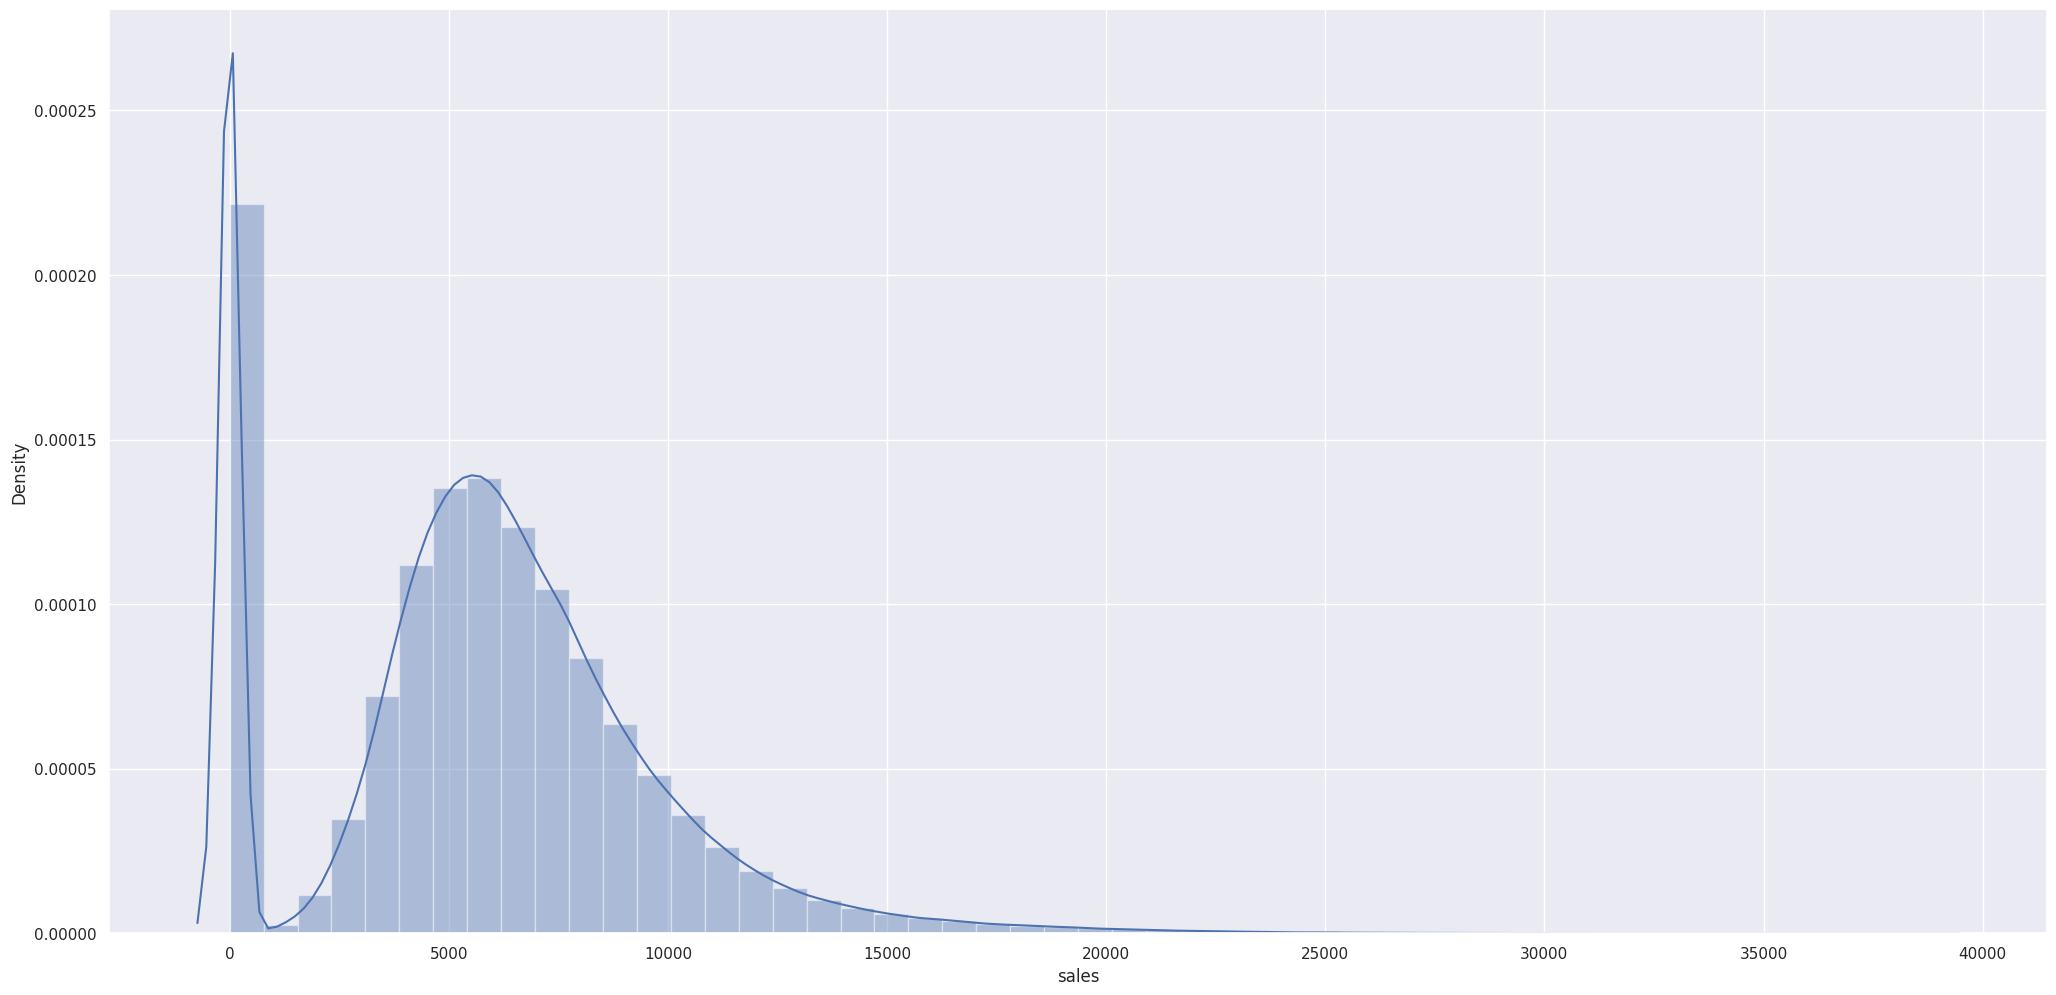

In [26]:
sns.distplot(df1["sales"])

/tmp/ipykernel_34833/4234290159.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1["competition_distance"])
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating 

<Axes: xlabel='competition_distance', ylabel='Density'>

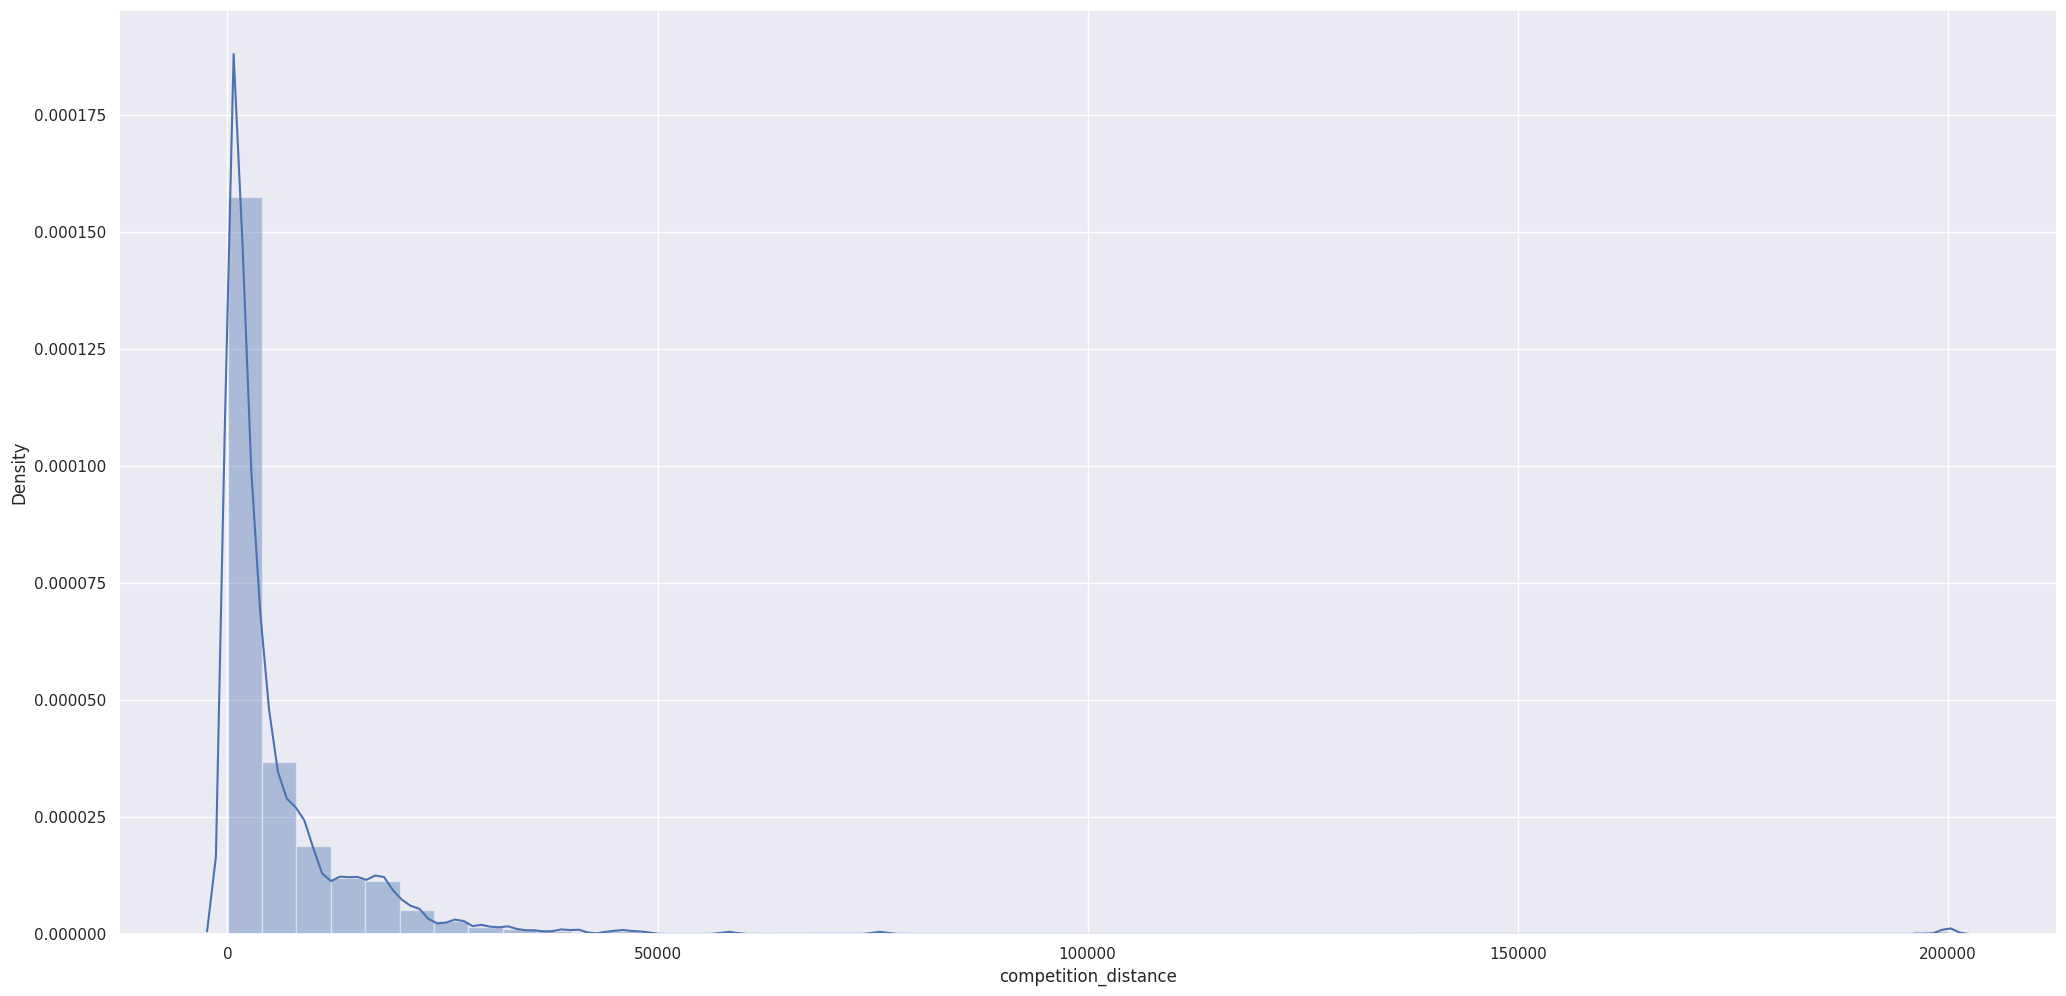

In [27]:
sns.distplot(df1["competition_distance"])

### 1.7.2 - Categorical Attributes

In [28]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarni

<Axes: xlabel='assortment', ylabel='sales'>

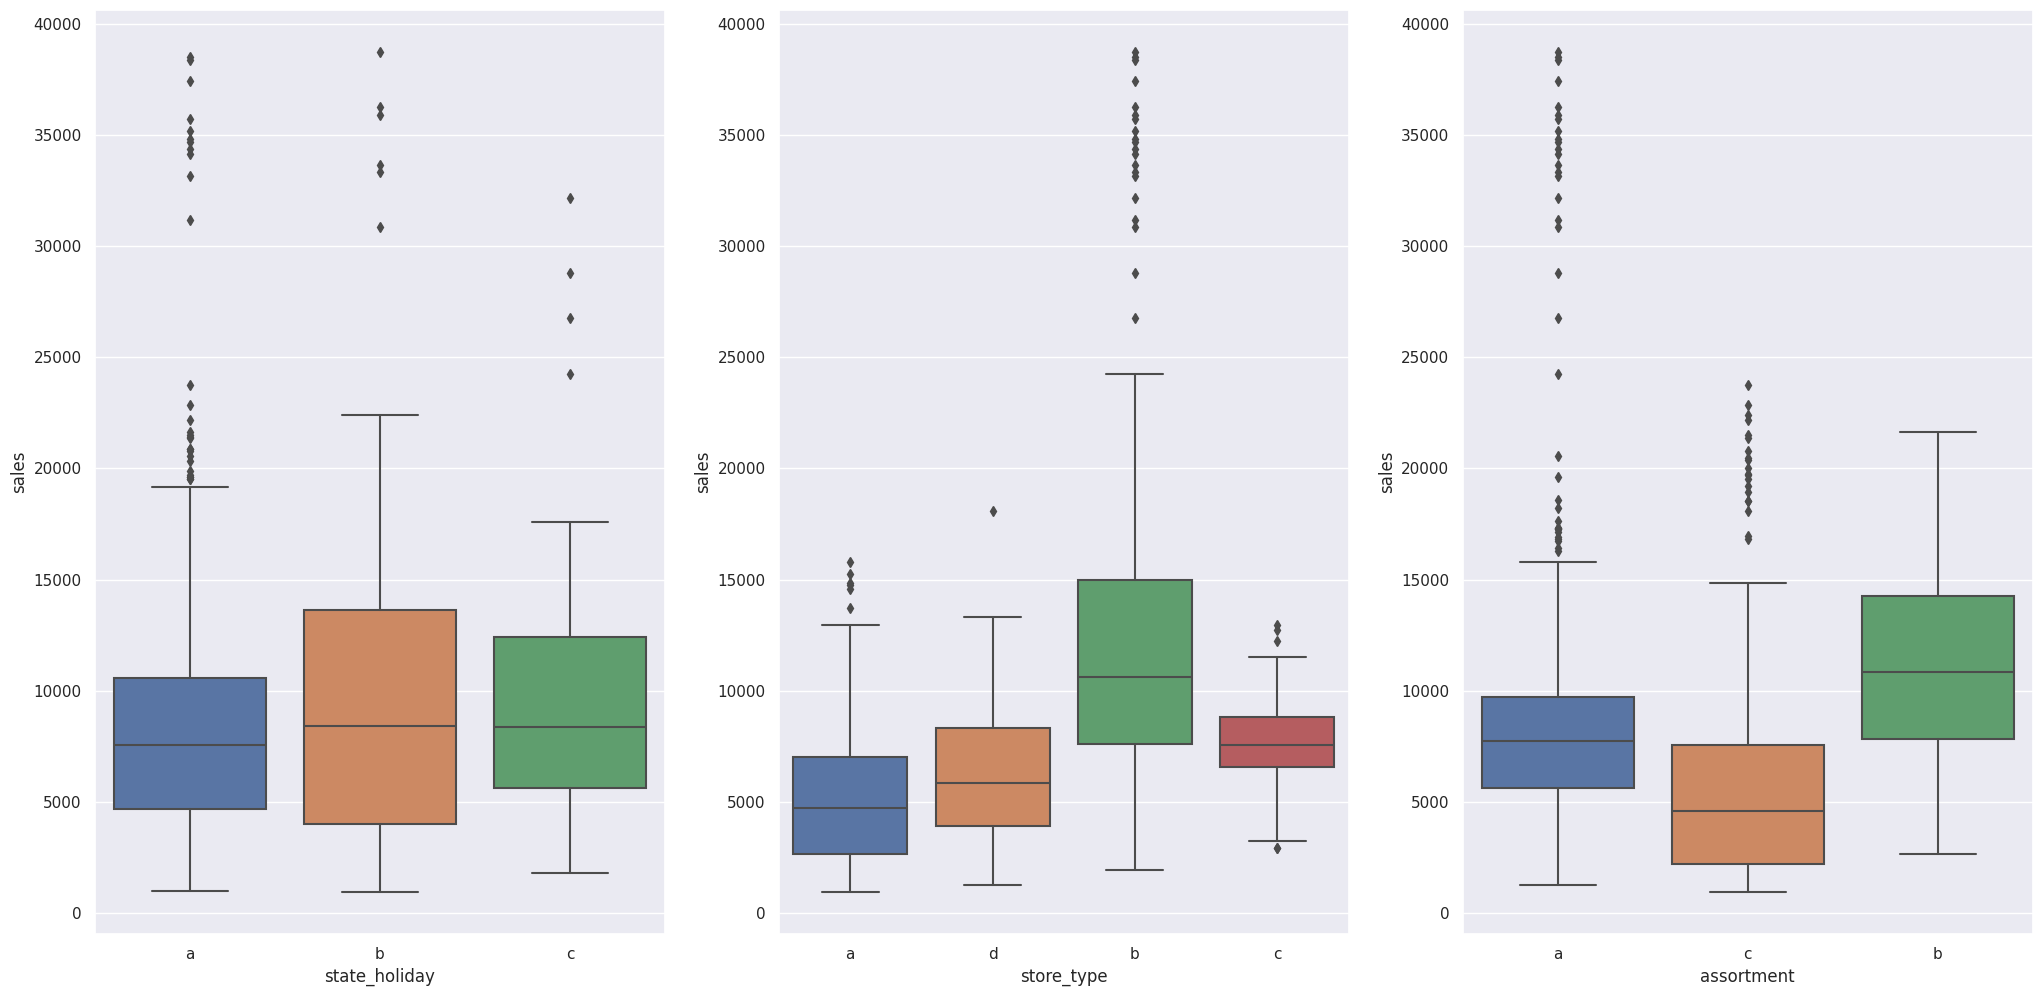

In [29]:
filters = (df1["state_holiday"] != "0") & (df1["sales"] > 0)
aux = df1.loc[filters, :]

plt.subplot(1, 3, 1)
sns.boxplot(x="state_holiday", y="sales", data=aux)
plt.subplot(1, 3, 2)
sns.boxplot(x="store_type", y="sales", data=aux)
plt.subplot(1, 3, 3)
sns.boxplot(x="assortment", y="sales", data=aux)

# 2.0 - Feature Engineering

In [30]:
df2 = df1.copy()

## 2.1 - Mapa Mental de Hipóteses

```mermaid
mindmap
    [Daily Stores Sales]
        )Cliente(
            Volume de Compra
            Número de Filhos
            Salário
            Idade
            Profissão
            Família
            Frequência de Compra
        )Localização(
            Perto de Escola
            Bairro
            Rural
            Urbano
            Centro
            Perto de Hospital
        )Temporal(
            Feriados
            Semana do Ano
            Dia
            Mês
            Ano
            Hora
            Fim de Semana
            Saldão
        )Lojas(
            Número de Funcionários
            Estoque
            Tamanho
            Sortimento
            Competidores
        )Produtos(
            Marketing
            Exposição na Loja
            Preço
            Estoque
            Promoção
```

## 2.2 - Criação de Hipóteses

### 2.2.1 - Hipóteses de **Loja**

**1.** Lojas com número maior de funcionários deveriam vender mais.  
**2.** Lojas com maior capacidade de estoque deveriam vender mais.  
**3.** Lojas com maior porte deveriam vender mais.  
**4.** Lojas com maior sortimentos deveriam vender mais.  
**5.** Lojas com competidores mais próximos deveriam vender menos.  
**6.** Lojas com competidores à mais tempo deveriam vendem mais.  

### 2.2.2 - Hipóteses de **Produto**

**1.** Lojas que investem mais em Marketing deveriam vender mais.  
**2.** Lojas com maior exposição de produto deveriam vender mais.  
**3.** Lojas com produtos com preço menor deveriam vender mais.  
**5.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.  
**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.  
**7.** Lojas com mais dias de promoção deveriam vender mais.  
**8.** Lojas com mais promoções consecutivas deveriam vender mais.  

### 2.2.3 - Hipóteses de **Tempo**

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.  
**2.** Lojas deveriam vender mais ao longo dos anos.  
**3.** Lojas deveriam vender mais no segundo semestre do ano.  
**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.  
**5.** Lojas deveriam vender menos aos finais de semana.  
**6.** Lojas deveriam vender menos durante os feriados escolares.  

## 2.3 - Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.  
**2.** Lojas com competidores mais próximos deveriam vender menos.  
**3.** Lojas com competidores à mais tempo deveriam vendem mais.  
**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.  
**5.** Lojas com mais dias de promoção deveriam vender mais.  
**6.** Lojas com mais promoções consecutivas deveriam vender mais.  
**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.  
**8.** Lojas deveriam vender mais ao longo dos anos.  
**9**. Lojas deveriam vender mais no segundo semestre do ano.  
**10**. Lojas deveriam vender mais depois do dia 10 de cada mês.  
**11**. Lojas deveriam vender menos aos finais de semana.  
**12**. Lojas deveriam vender menos durante os feriados escolares.  

## 2.4 - Feature Engineering

In [31]:
# Creating datetimes

# Year
df2["year"] = df2["date"].dt.year

# Month
df2["month"] = df2["date"].dt.month

# Day
df2["day"] = df2["date"].dt.day

# Week of Year
df2["week_of_year"] = df2["date"].dt.isocalendar().week

# Year Week
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")

In [ ]:
# Competition Since
df2["competition_since"] = df2.apply(
    lambda x: datetime.datetime(
        year=x["competition_open_since_year"],
        month=x["competition_open_since_month"],
        day=1,
    ),
    axis=1,
)
df2["competition_time_month"] = (
    ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)
)

: 

In [ ]:
# Promo Since
df2["promo_since"] = (
    df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)
)
df2["promo_since"] = df2["promo_since"].apply(
    lambda x: datetime.datetime.strptime(x + "-1", "%Y-%W-%w")
    - datetime.timedelta(days=7)
)
df2["promo_time_week"] = (
    ((df2["date"] - df2["promo_since"]) / 7).apply(lambda x: x.days).astype(int)
)

In [ ]:
# Assortment
df2["assortment"] = df2["assortment"].apply(
    lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended"
)

# State Holiday
df2["state_holiday"] = df2["state_holiday"].apply(
    lambda x: "public_holiday"
    if x == "a"
    else "easter_holiday"
    if x == "b"
    else "christmas"
    if x == "c"
    else "regular_day"
)

In [ ]:
df2.sample(5).T

,629342,291869,330148,290560,1016861
store,153,387,326,1057,767
day_of_week,6,7,1,2,2
date,2013-12-14 00:00:00,2014-11-02 00:00:00,2014-09-22 00:00:00,2014-11-04 00:00:00,2013-01-01 00:00:00
sales,5489,0,3677,6550,0
customers,498,0,339,627,0
open,1,0,1,1,0
promo,0,0,0,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,public_holiday
school_holiday,0,0,0,0,1
store_type,a,c,d,d,a


# 3.0 - Filtragem de Variáveis

In [ ]:
df3 = df2.copy()

## 3.1 - Filtragem de Linhas

In [ ]:
df3 = df3.loc[(df3["open"] != 0) & (df3["sales"] > 0), :]

## 3.2 - Filtragem de Colunas

In [ ]:
df3 = df3.drop(["customers", "open", "promo_interval", "month_map"], axis=1)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 - Análise Exploratória de Dados (EDA)

In [ ]:
df4 = df3.copy()

## 4.1 - Análise Univariada

### 4.1.1 - Variável Resposta

/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


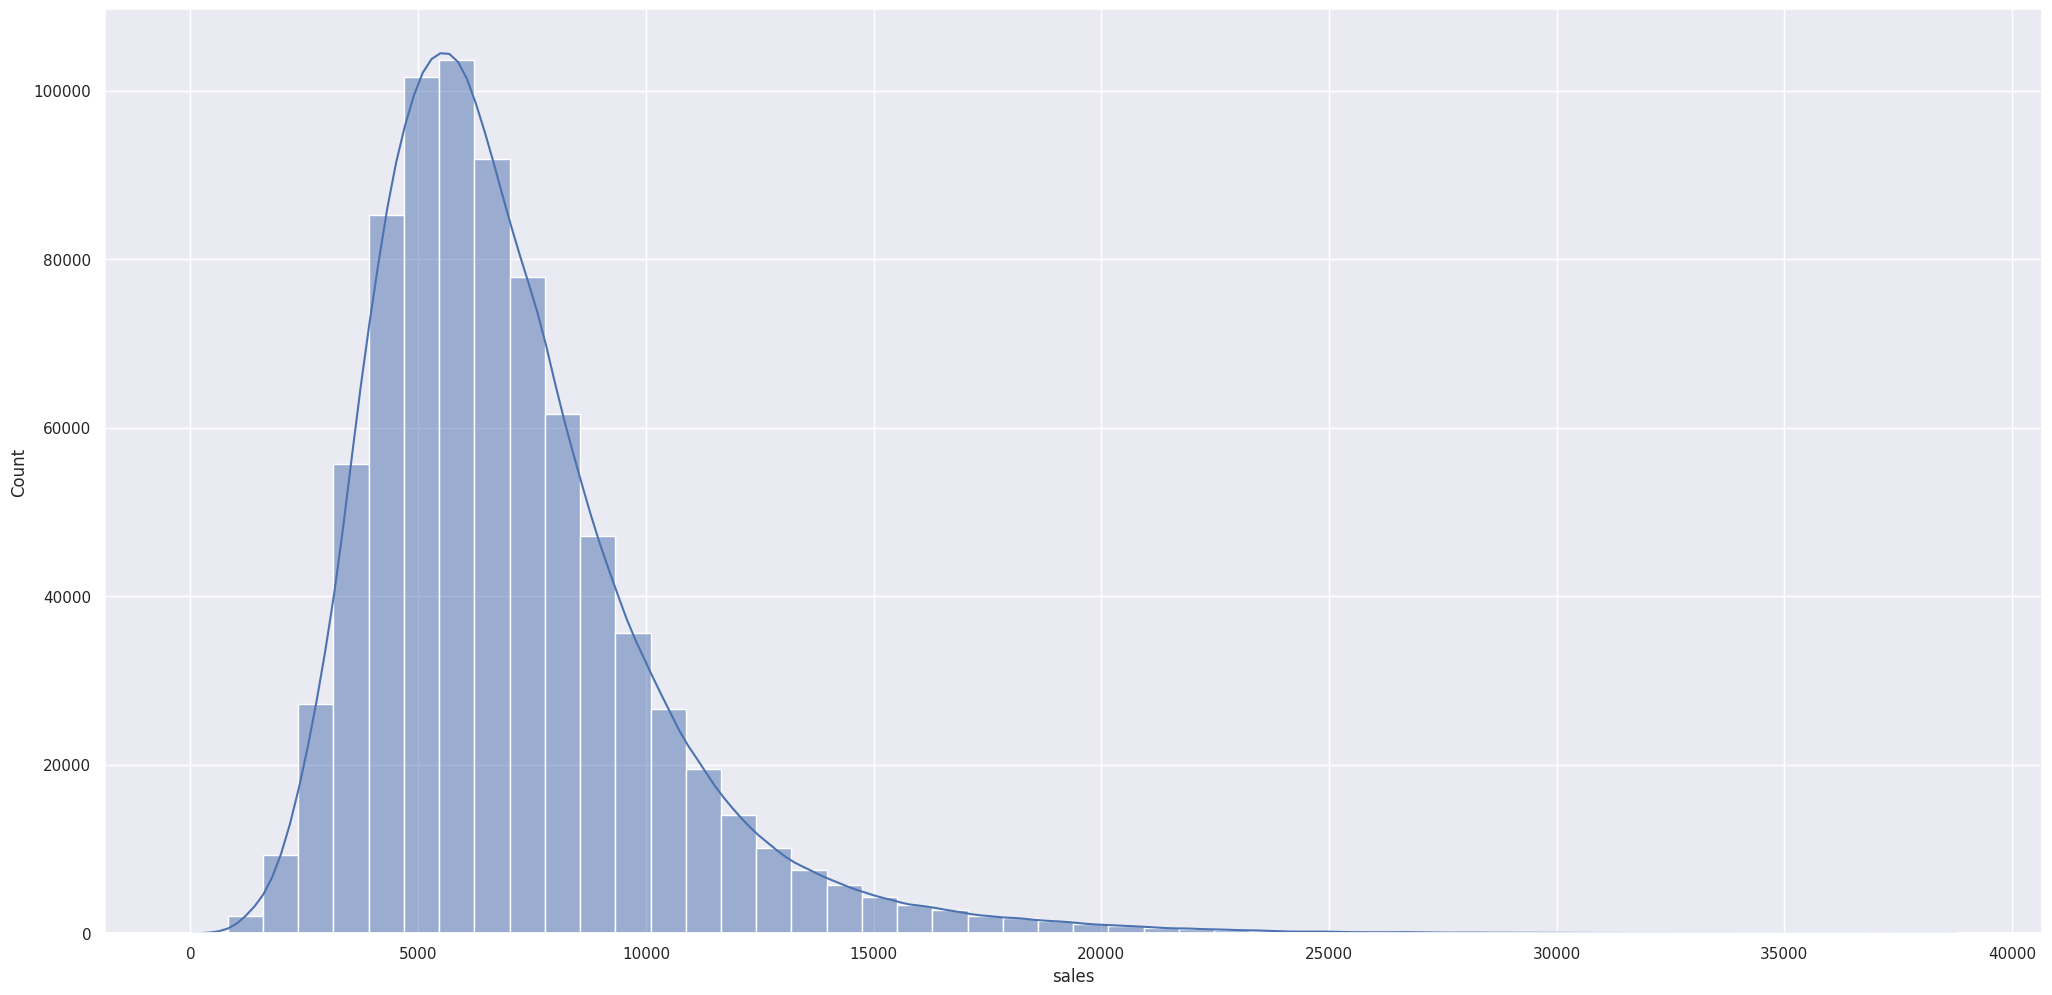

In [ ]:
sns.histplot(df4["sales"], kde=True, bins=50);

### 4.1.2 - Variáveis Numéricas

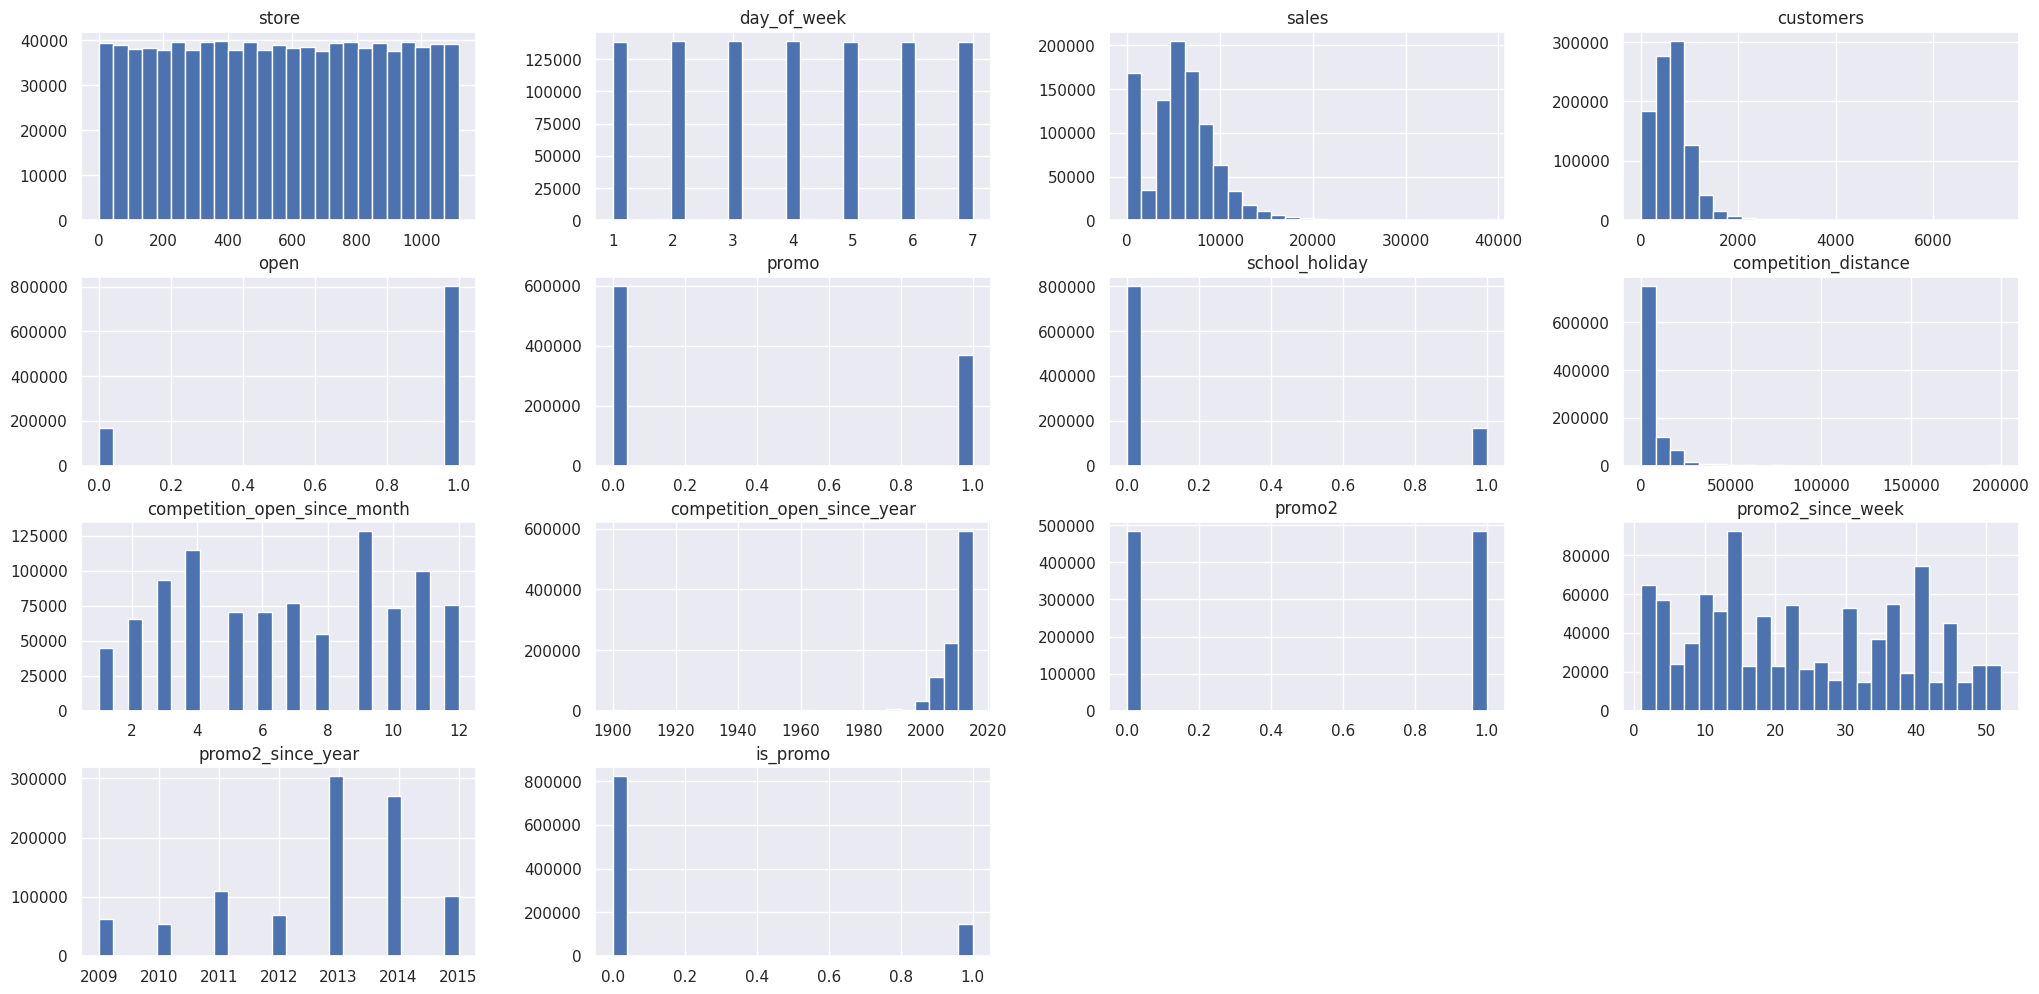

In [ ]:
num_attributes.hist(bins=25);

### 4.1.3 - Variáveis Categóricas

In [ ]:
df4["state_holiday"].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [ ]:
df4["store_type"].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [ ]:
df4["assortment"].unique()

array(['basic', 'extended', 'extra'], dtype=object)

/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarni

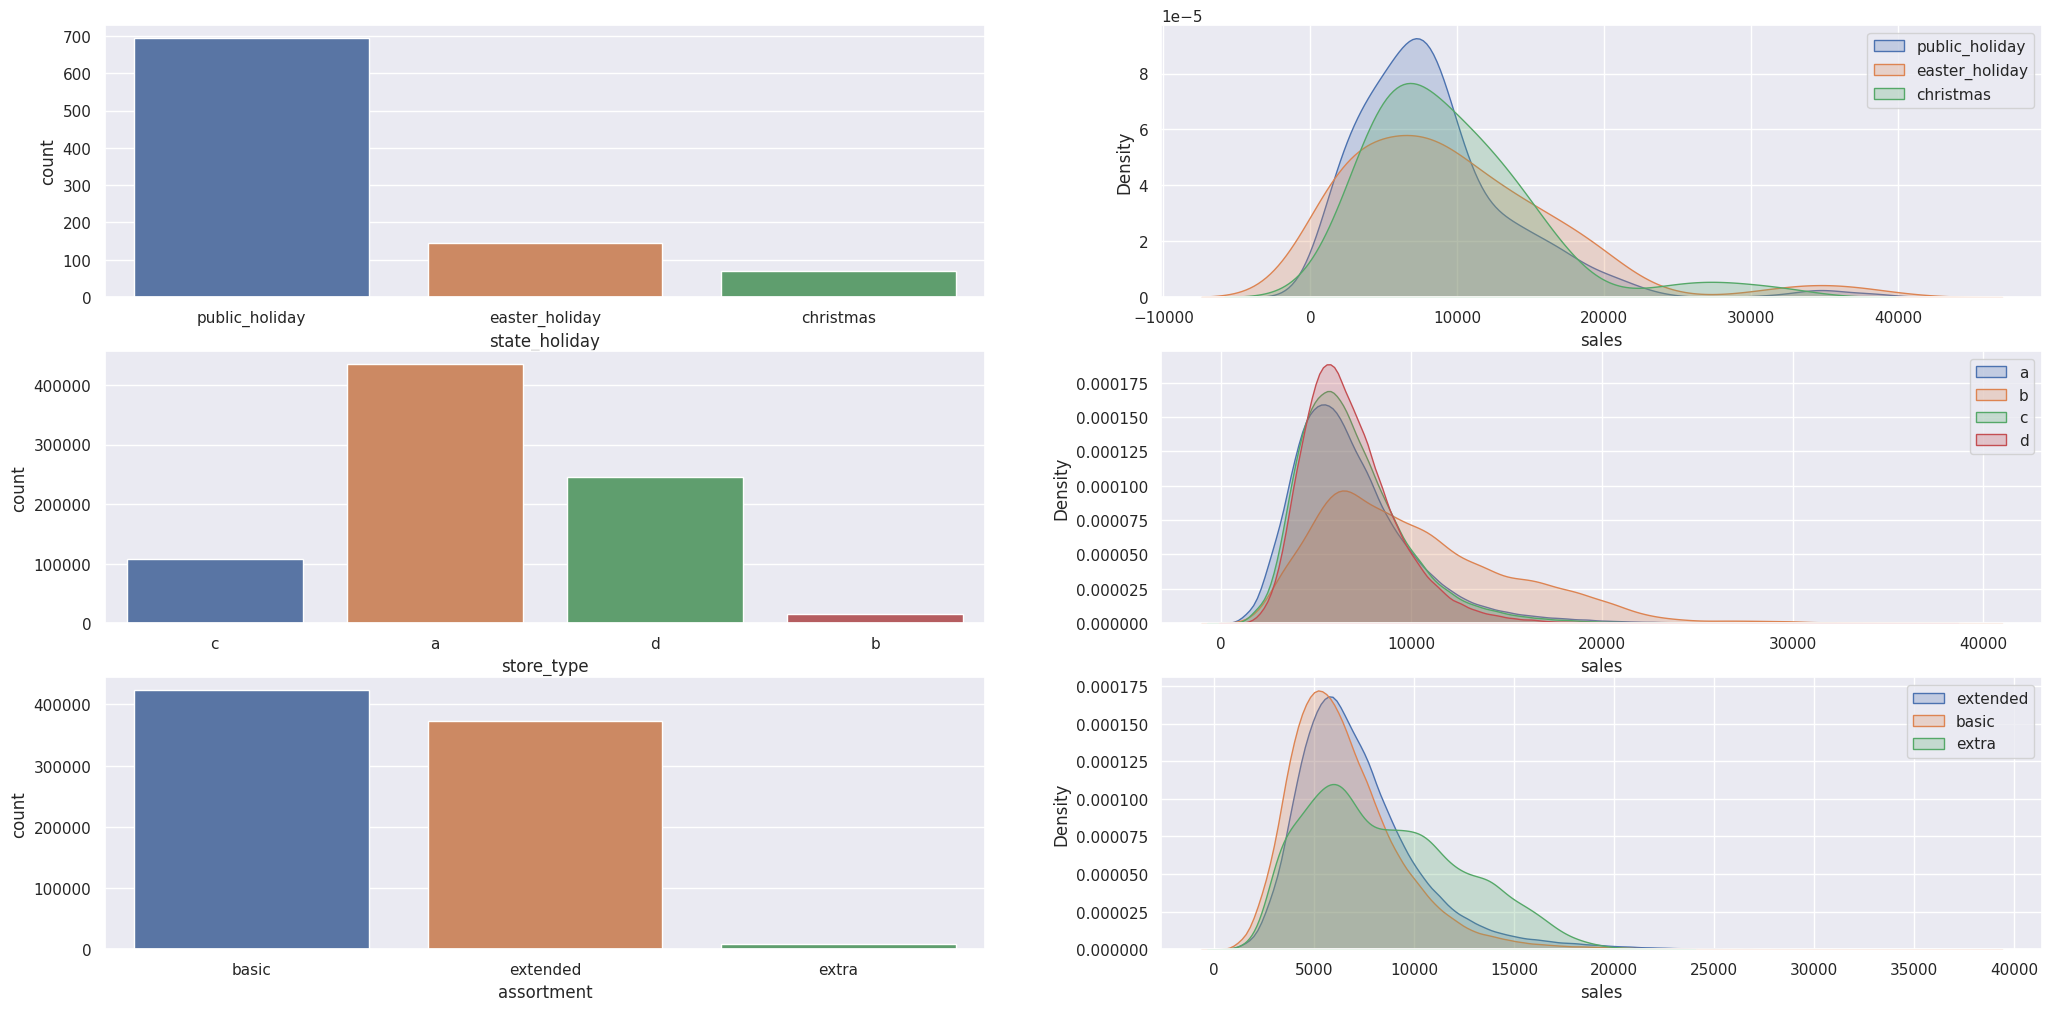

In [ ]:
# state_holiday
plt.subplot(3, 2, 1)
df_aux = df4.loc[df4["state_holiday"] != "regular_day"]
sns.countplot(x=df_aux["state_holiday"])

plt.subplot(3, 2, 2)
sns.kdeplot(
    df4[df4["state_holiday"] == "public_holiday"]["sales"],
    label="public_holiday",
    fill=True,
).legend(loc="upper right")
sns.kdeplot(
    df4[df4["state_holiday"] == "easter_holiday"]["sales"],
    label="easter_holiday",
    fill=True,
).legend(loc="upper right")
sns.kdeplot(
    df4[df4["state_holiday"] == "christmas"]["sales"], label="christmas", fill=True
).legend(loc="upper right")

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x=df4["store_type"])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4["store_type"] == "a"]["sales"], label="a", fill=True).legend(
    loc="upper right"
)
sns.kdeplot(df4[df4["store_type"] == "b"]["sales"], label="b", fill=True).legend(
    loc="upper right"
)
sns.kdeplot(df4[df4["store_type"] == "c"]["sales"], label="c", fill=True).legend(
    loc="upper right"
)
sns.kdeplot(df4[df4["store_type"] == "d"]["sales"], label="d", fill=True).legend(
    loc="upper right"
)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x=df4["assortment"])

plt.subplot(3, 2, 6)
sns.kdeplot(
    df4[df4["assortment"] == "extended"]["sales"], label="extended", fill=True
).legend(loc="upper right")
sns.kdeplot(
    df4[df4["assortment"] == "basic"]["sales"], label="basic", fill=True
).legend(loc="upper right")
sns.kdeplot(
    df4[df4["assortment"] == "extra"]["sales"], label="extra", fill=True
).legend(loc="upper right")

## 4.2 - Análise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.  
**FALSA** Lojas com **MAIOR SORTIMENTO** vendem **MENOS**.

/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='year_week'>

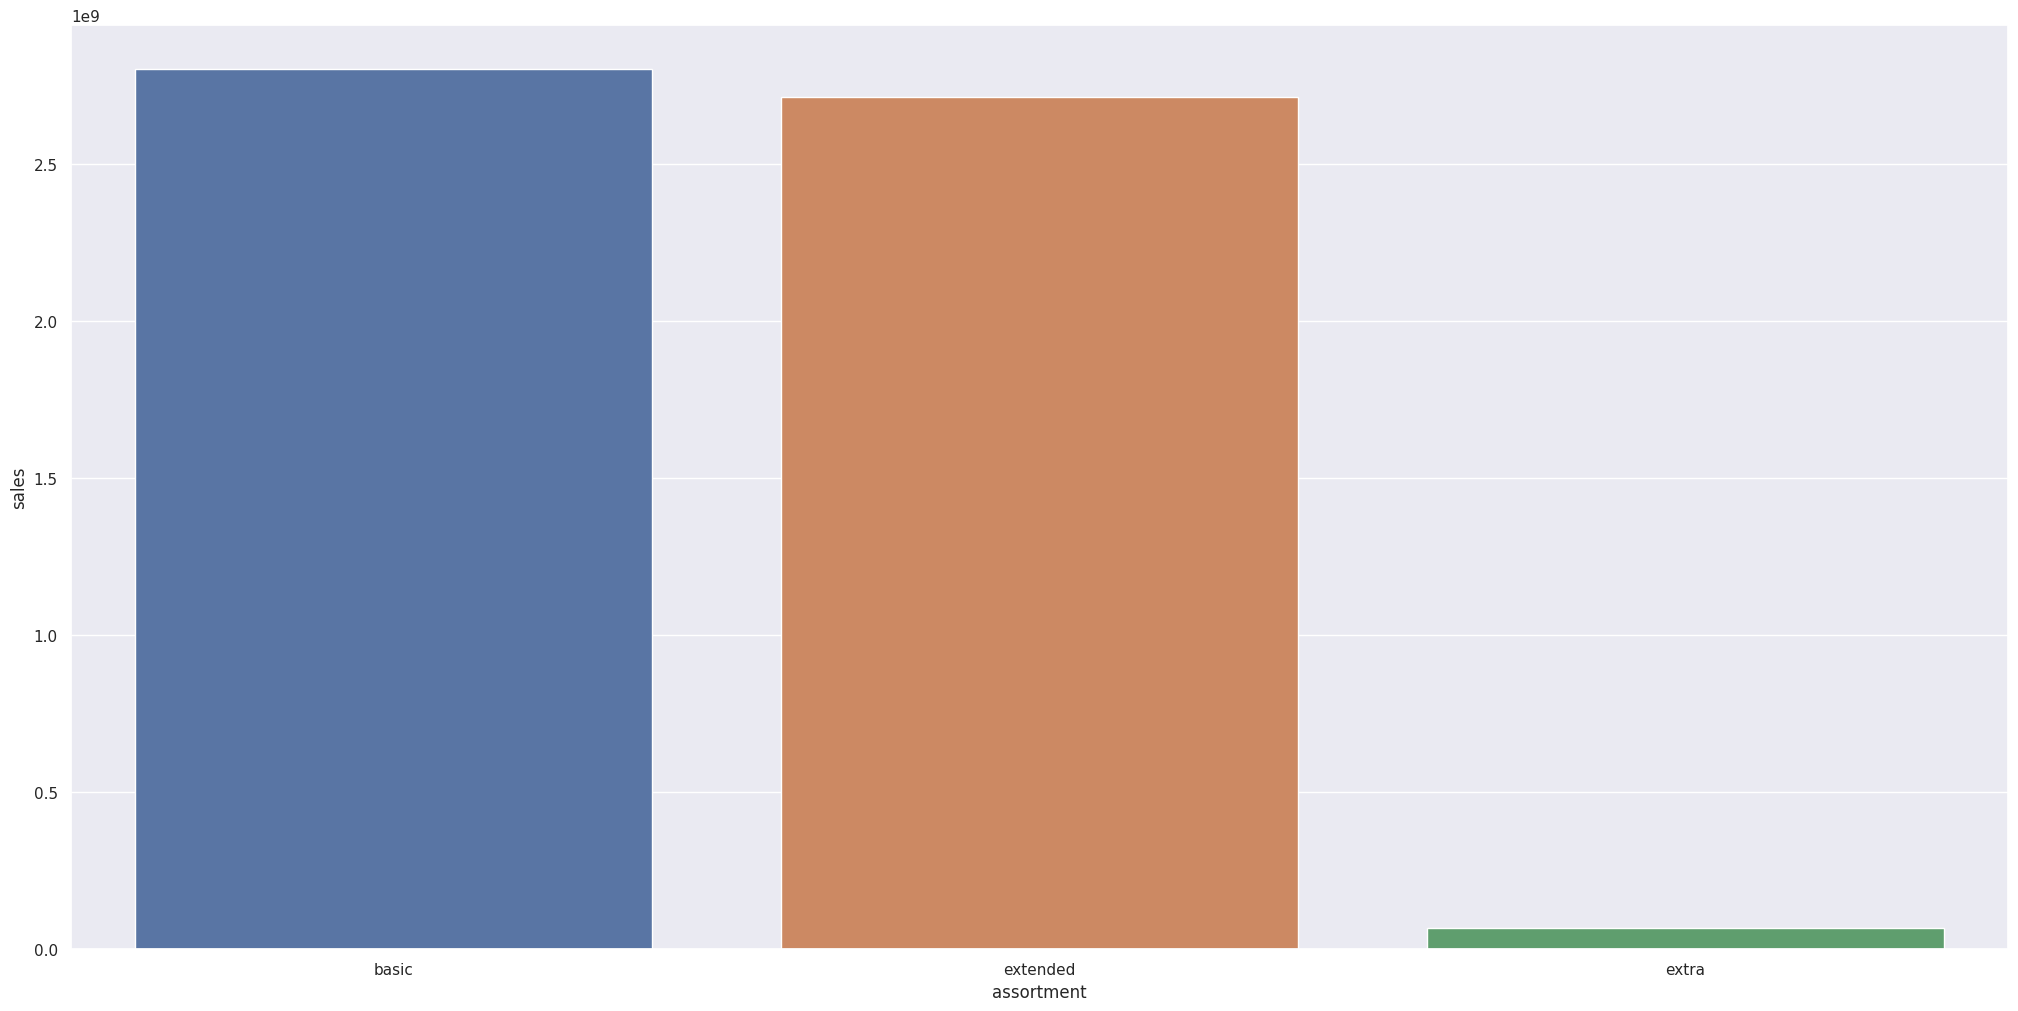

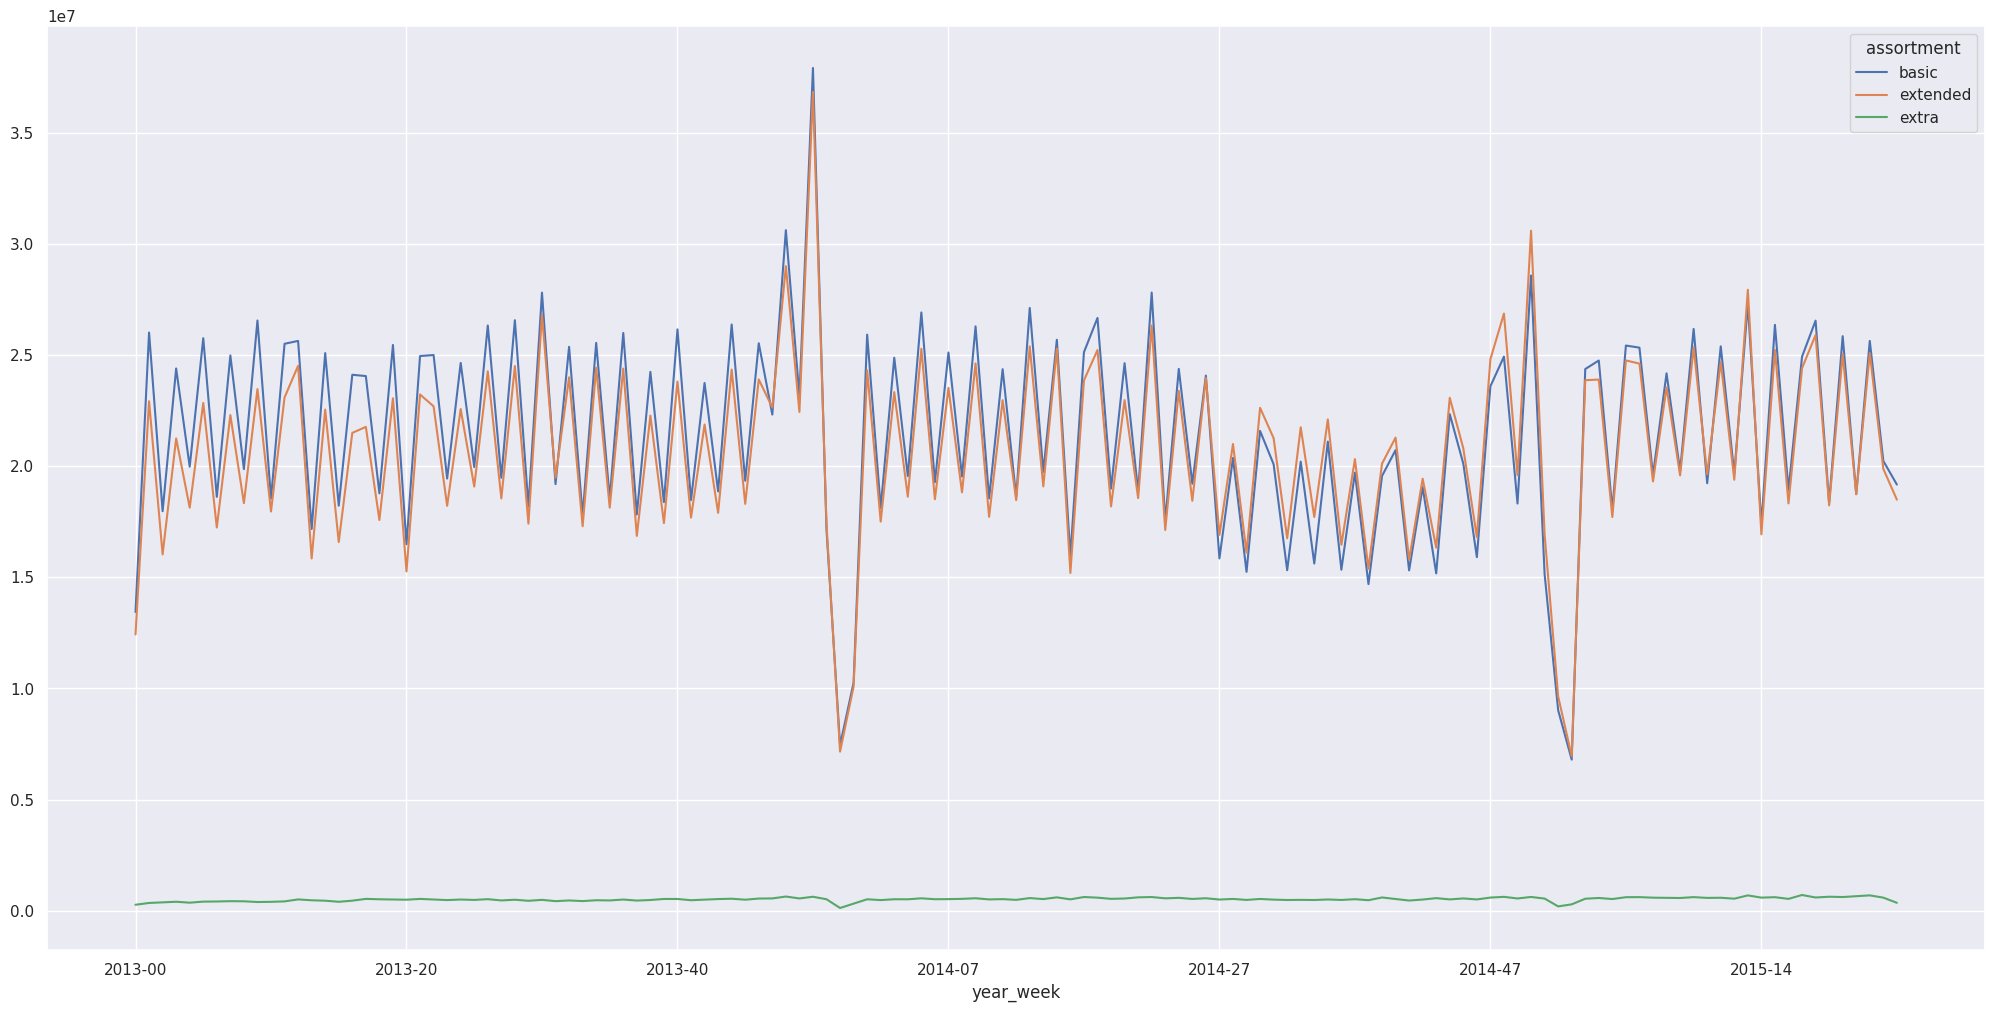

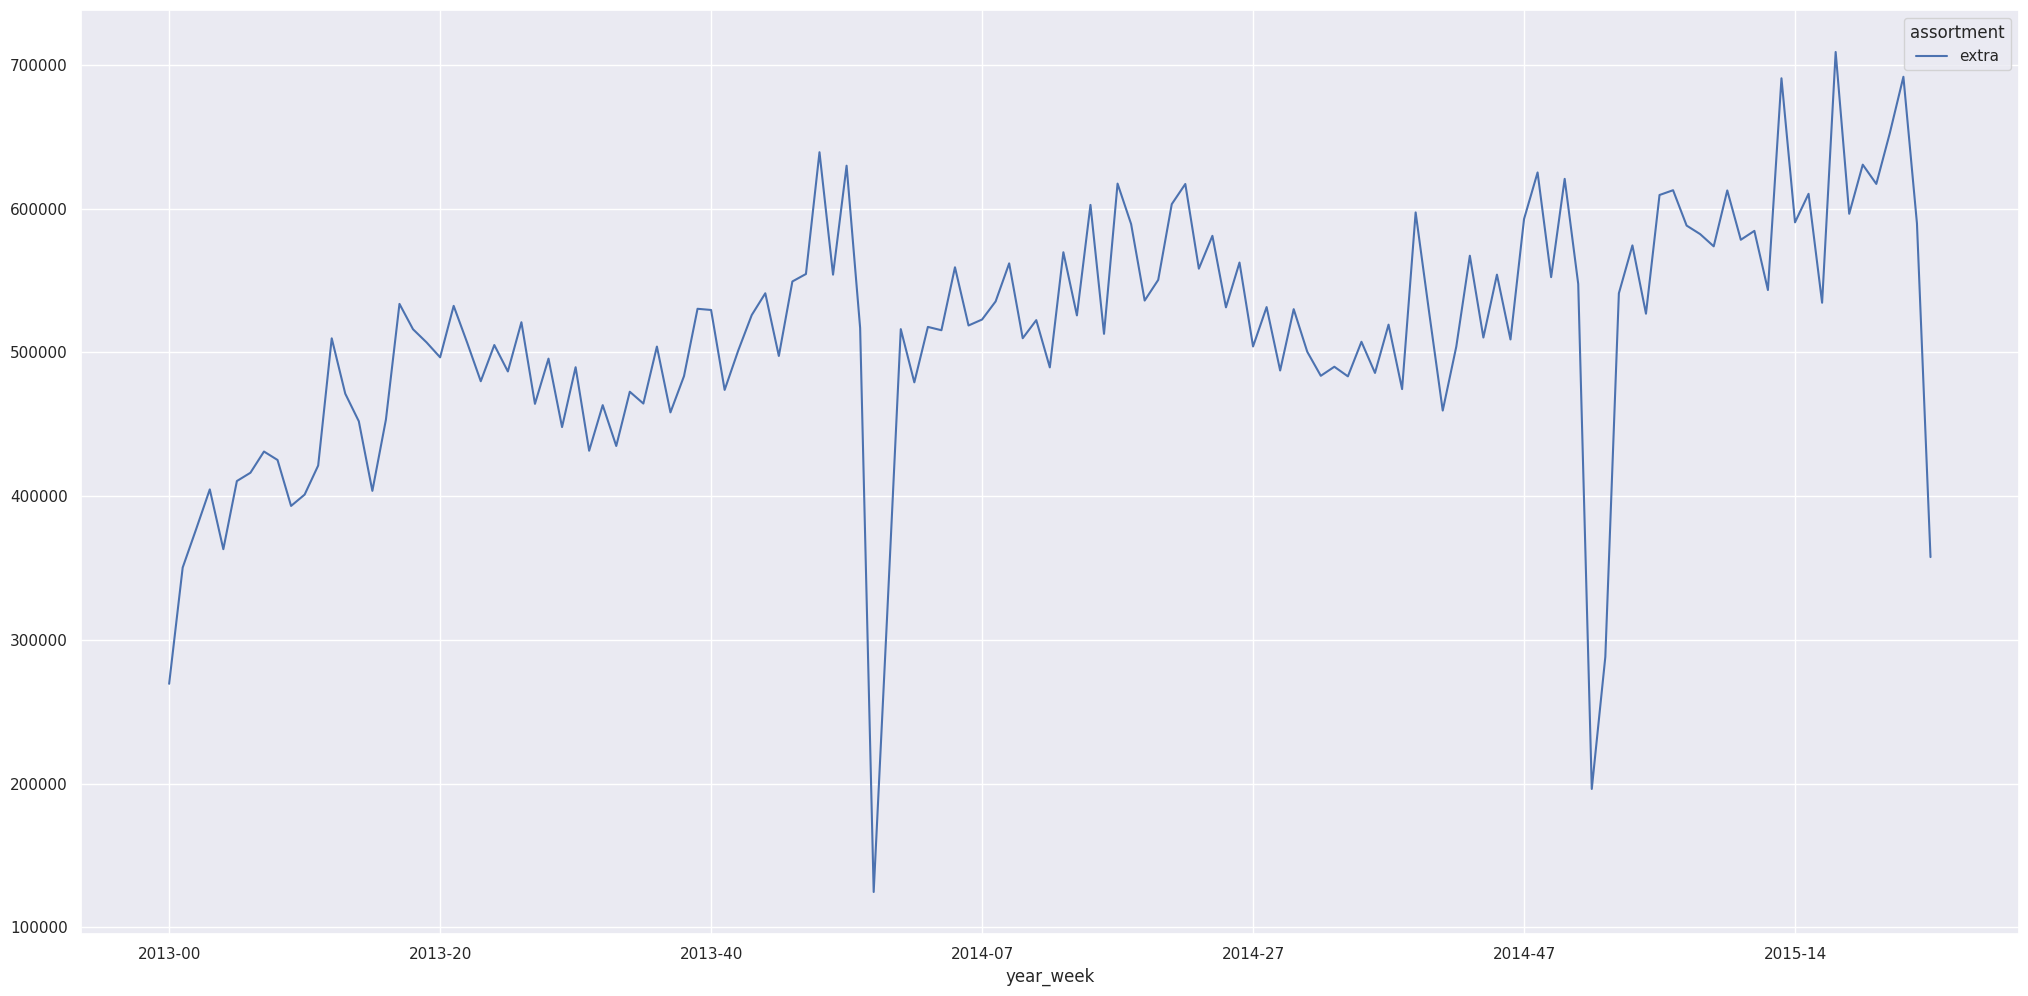

In [ ]:
aux1 = df4.loc[:, ["assortment", "sales"]].groupby(["assortment"]).sum().reset_index()
sns.barplot(x="assortment", y="sales", data=aux1)

aux2 = (
    df4.loc[:, ["year_week", "assortment", "sales"]]
    .groupby(["year_week", "assortment"])
    .sum()
    .reset_index()
)
aux2.pivot(index="year_week", columns="assortment", values="sales").plot()

aux3 = aux2.loc[aux2["assortment"] == "extra", :]
aux3.pivot(index="year_week", columns="assortment", values="sales").plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.  
**FALSA** Lojas com **COMPETIDORES MAIS PRÓXIMOS** vendem **MAIS**.

/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_28342/1429715287.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["competition_distance_binned"])
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_old

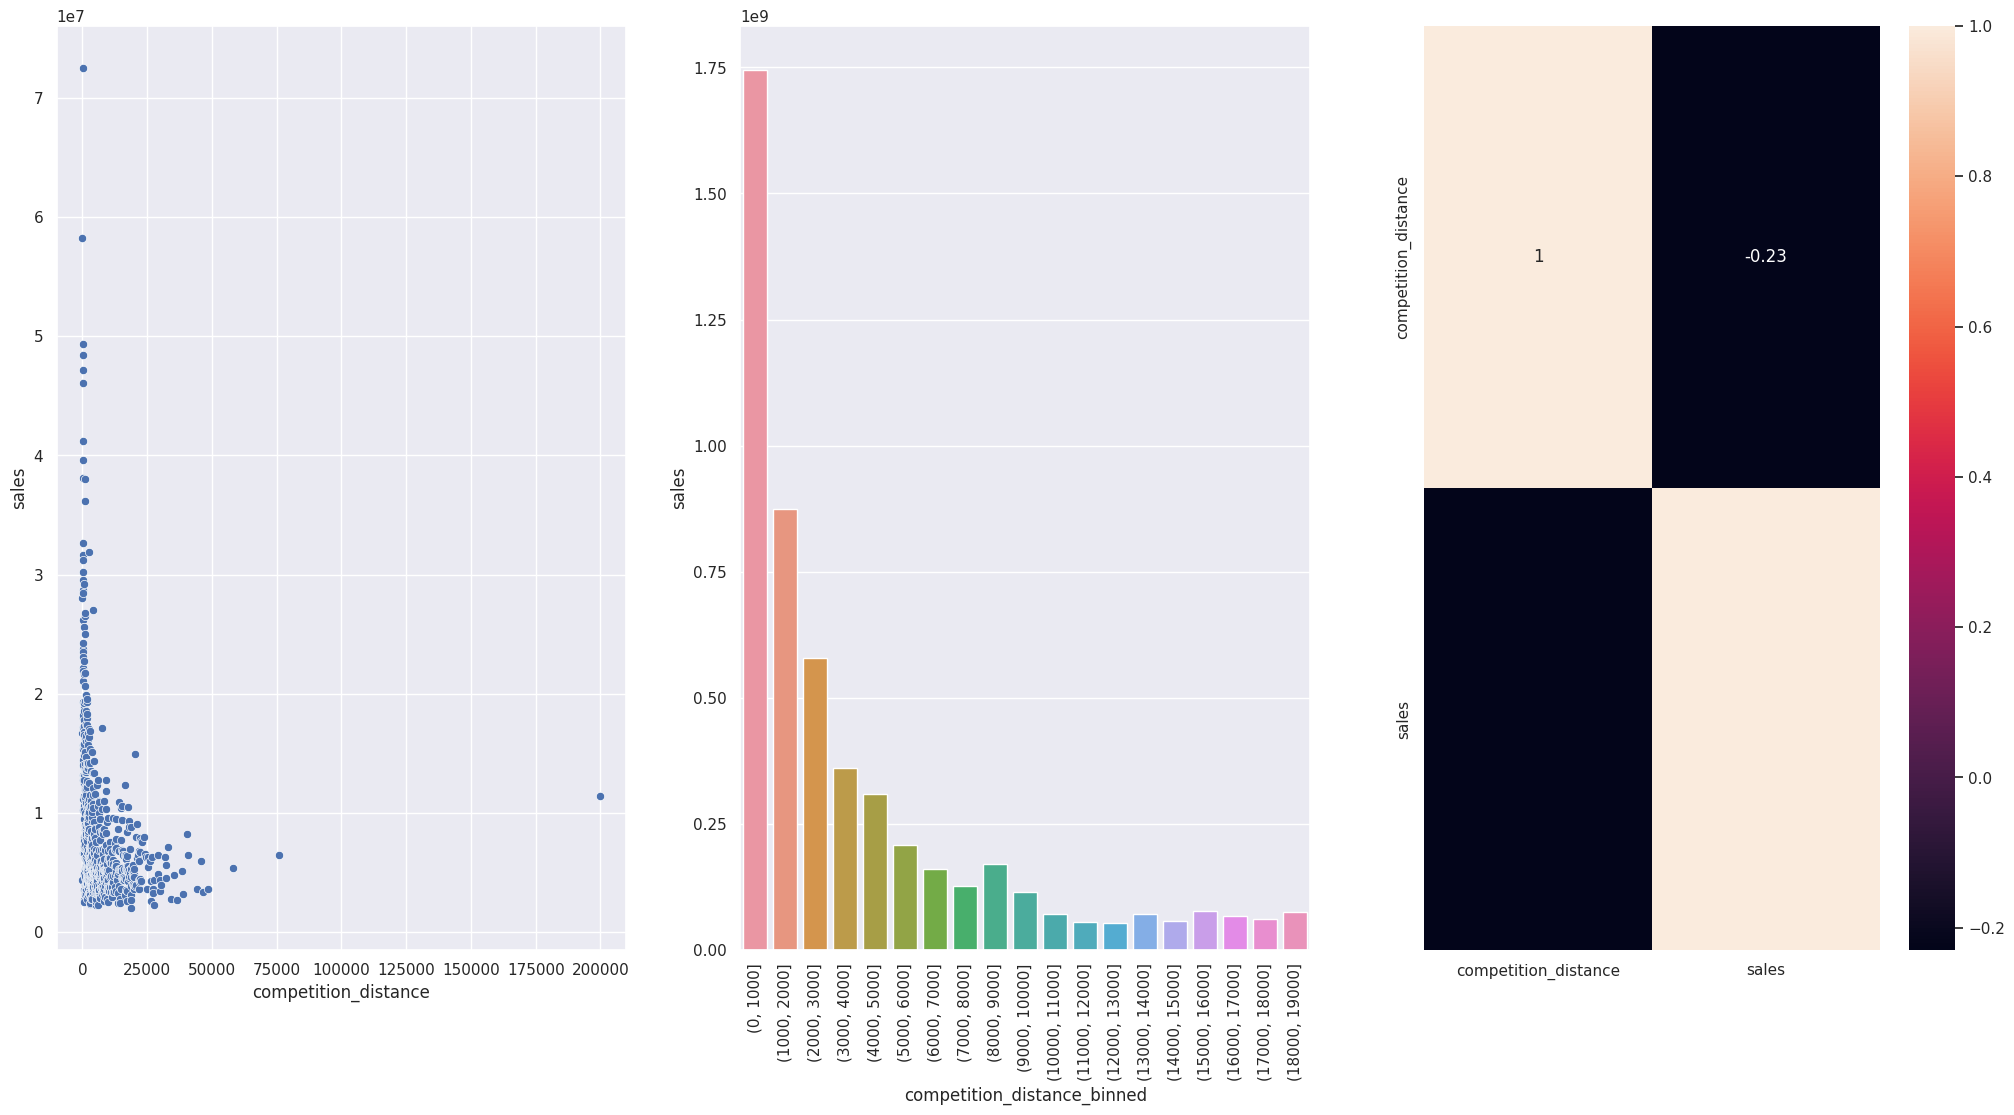

In [ ]:
aux1 = (
    df4.loc[:, ["competition_distance", "sales"]]
    .groupby(["competition_distance"])
    .sum()
    .reset_index()
)

plt.subplot(1, 3, 1)
sns.scatterplot(x="competition_distance", y="sales", data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux2 = aux1.copy()
aux2["competition_distance_binned"] = pd.cut(aux1["competition_distance"], bins=bins)
aux3 = (
    aux2.loc[:, ["competition_distance_binned", "sales"]]
    .groupby(["competition_distance_binned"])
    .sum()
    .reset_index()
)
sns.barplot(x="competition_distance_binned", y="sales", data=aux3)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.  
**FALSA** Lojas com **COMPETIDORES À MAIS TEMPO** vendem **MENOS**.

/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


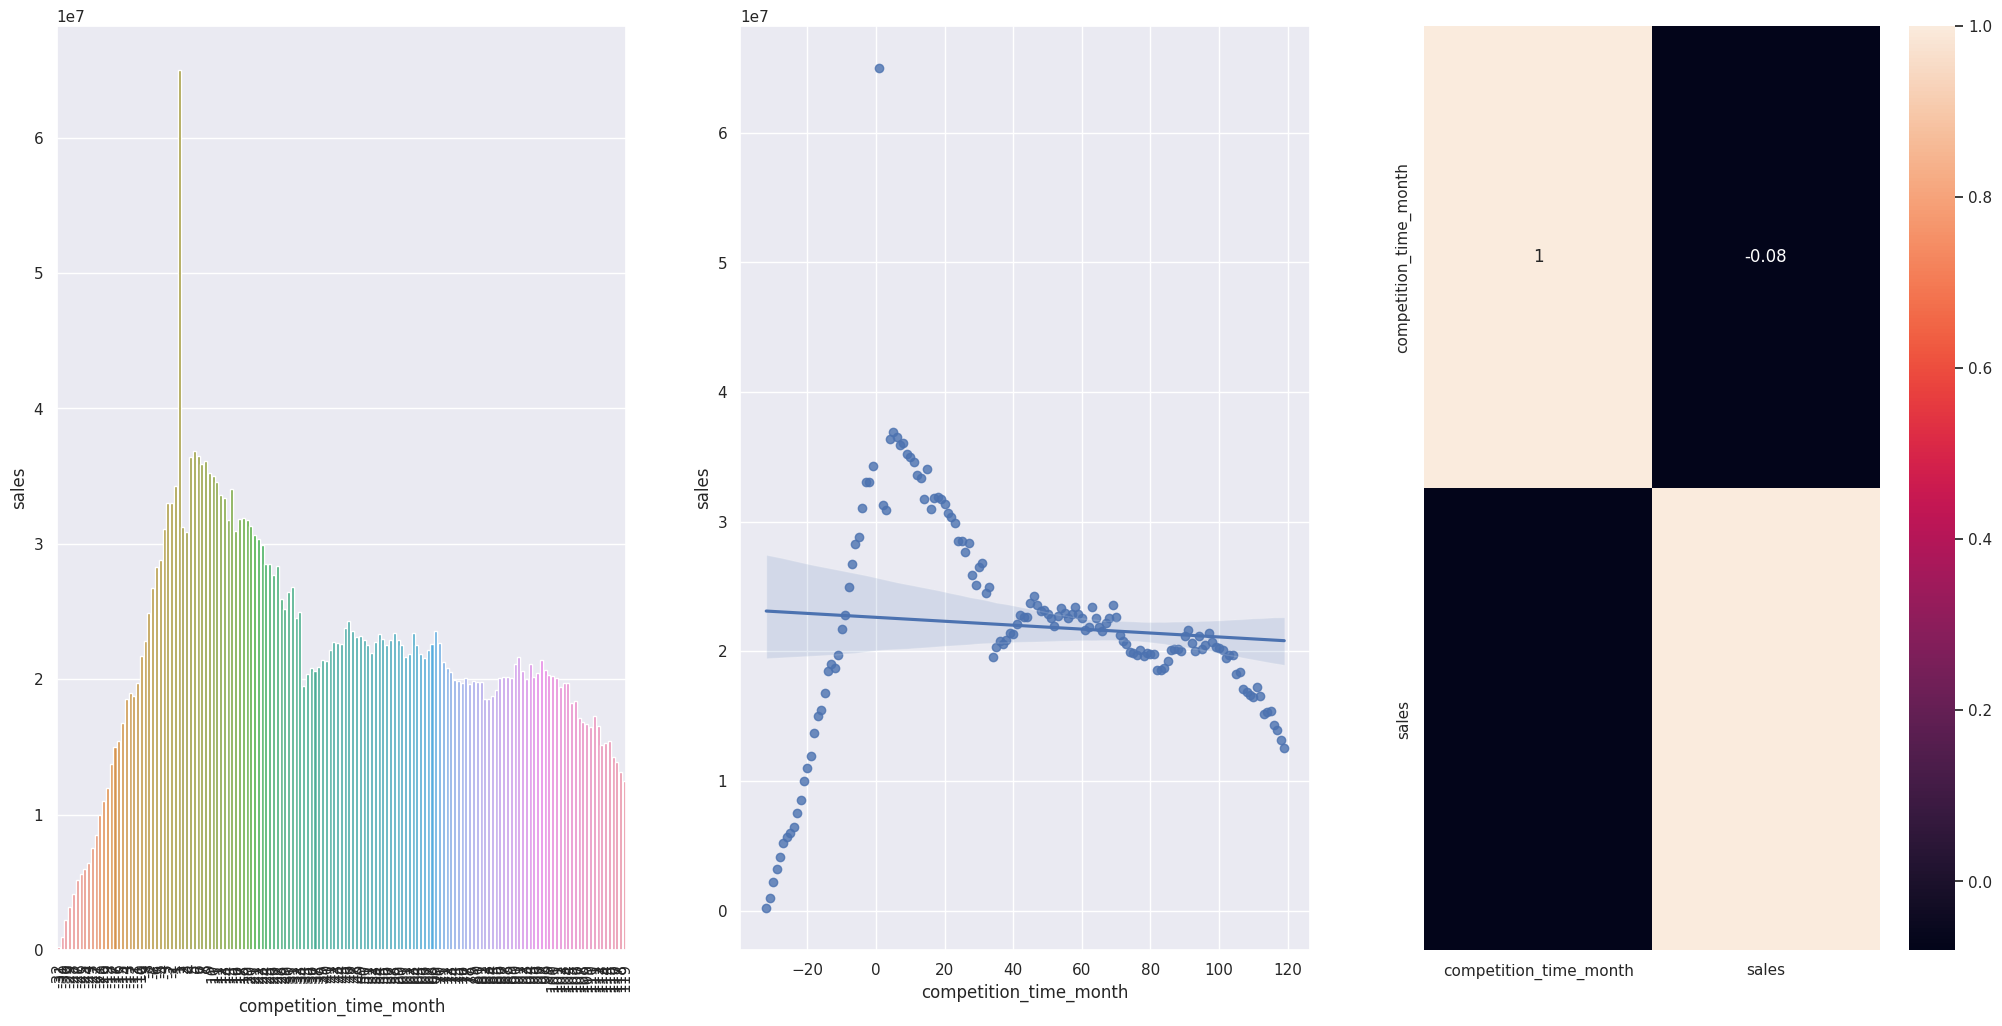

In [ ]:
aux1 = (
    df4.loc[:, ["competition_time_month", "sales"]]
    .groupby(["competition_time_month"])
    .sum()
    .reset_index()
)

aux2 = aux1.loc[
    (aux1["competition_time_month"] < 120) & (aux1["competition_time_month"] != 0), :
]

plt.subplot(1, 3, 1)
sns.barplot(x="competition_time_month", y="sales", data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x="competition_time_month", y="sales", data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux2.corr(method="pearson"), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.  
**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodode promoção

/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarni

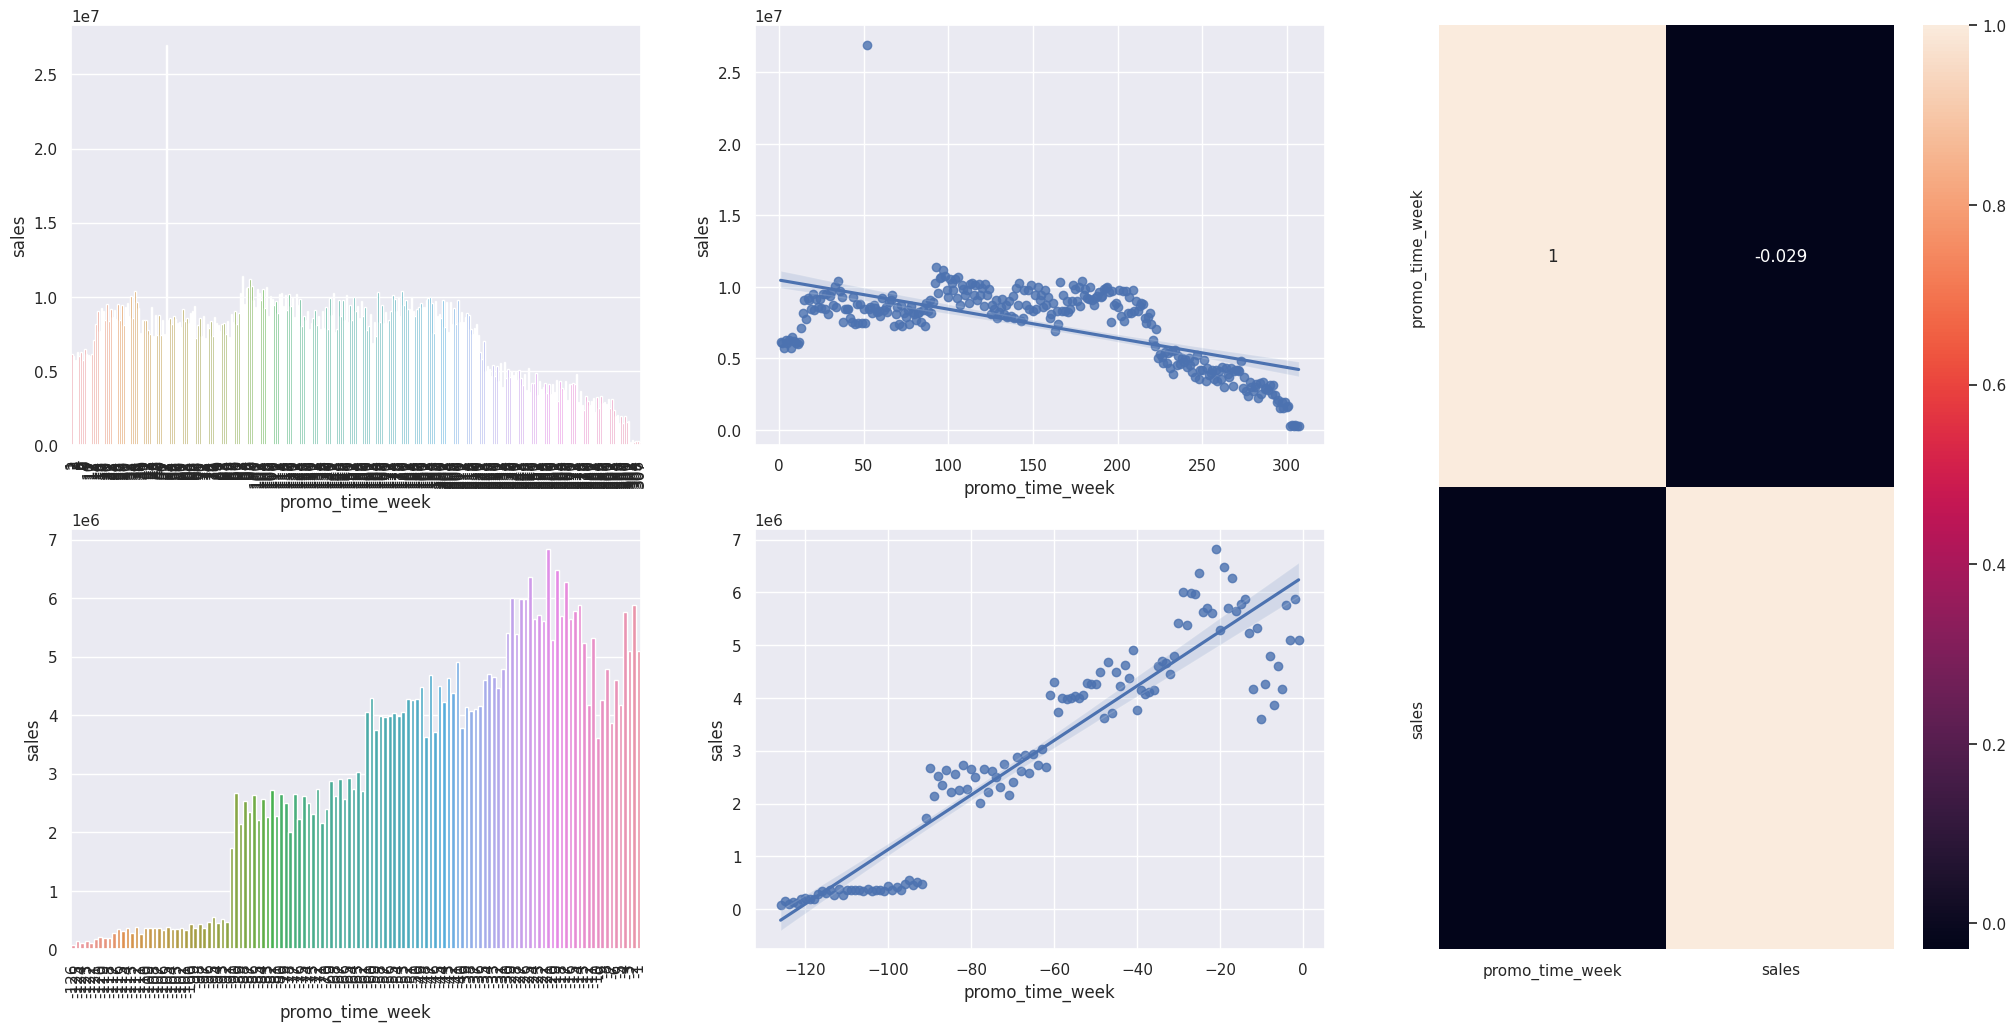

In [ ]:
aux1 = (
    df4.loc[:, ["promo_time_week", "sales"]]
    .groupby(["promo_time_week"])
    .sum()
    .reset_index()
)

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1.loc[aux1["promo_time_week"] > 0]  # promo extendido
sns.barplot(x="promo_time_week", y="sales", data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0, 1])
sns.regplot(x="promo_time_week", y="sales", data=aux2)

plt.subplot(grid[1, 0])
aux3 = aux1.loc[aux1["promo_time_week"] < 0]  # promo regular
sns.barplot(x="promo_time_week", y="sales", data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1, 1])
sns.regplot(x="promo_time_week", y="sales", data=aux3)

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method="pearson"), annot=True);

### **H5.** Lojas com mais dias de promoção deveriam vender mais.  

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.  
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [ ]:
df4.loc[:, ["promo", "promo2", "sales"]].groupby(
    ["promo", "promo2"]
).sum().reset_index()

,promo,promo2,sales
0,0,0,1409832377
1,0,1,1222887361
2,1,0,1552158182
3,1,1,1398730953


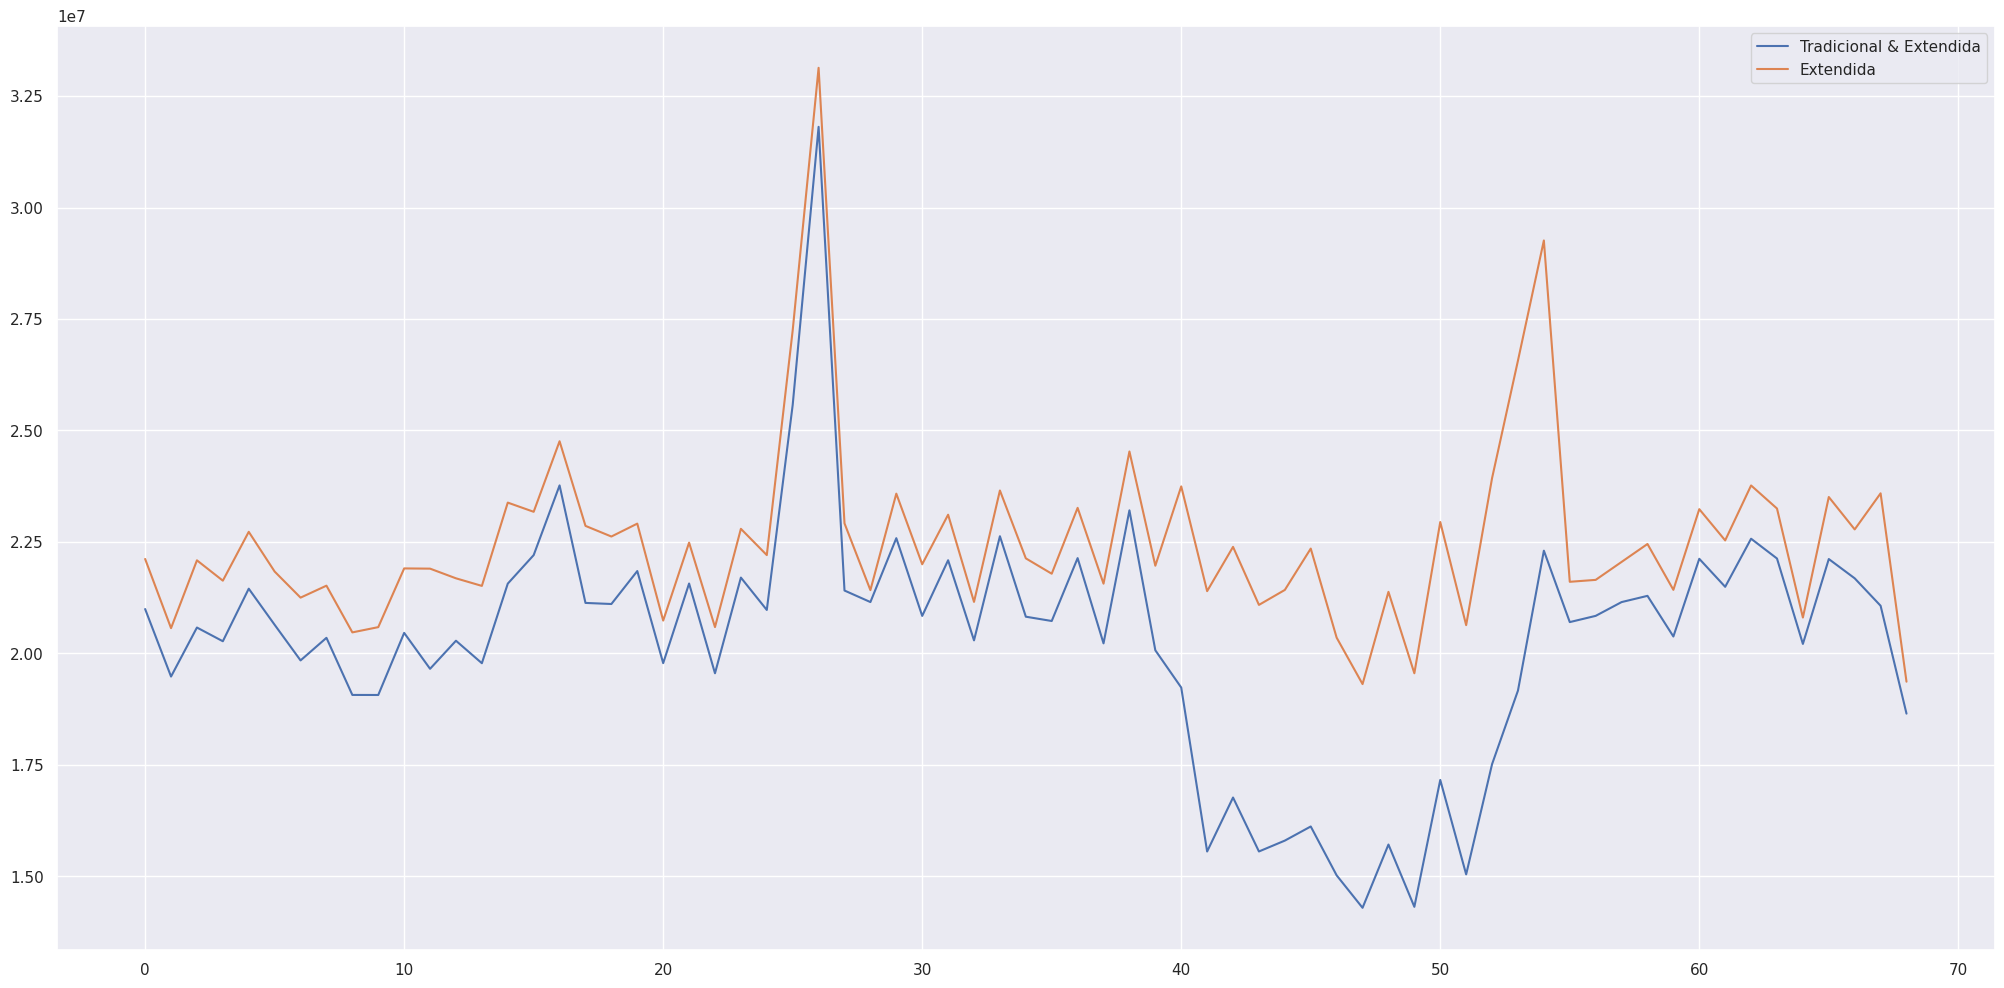

In [ ]:
aux1 = (
    df4.loc[(df4["promo"] == 1) & (df4["promo2"] == 1), ["year_week", "sales"]]
    .groupby(["year_week"])
    .sum()
    .reset_index()
)
ax = aux1.plot()

aux2 = (
    df4.loc[(df4["promo"] == 1) & (df4["promo2"] == 0), ["year_week", "sales"]]
    .groupby(["year_week"])
    .sum()
    .reset_index()
)
aux2.plot(ax=ax)
ax.legend(labels=["Tradicional & Extendida", "Extendida"]);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.  
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarni

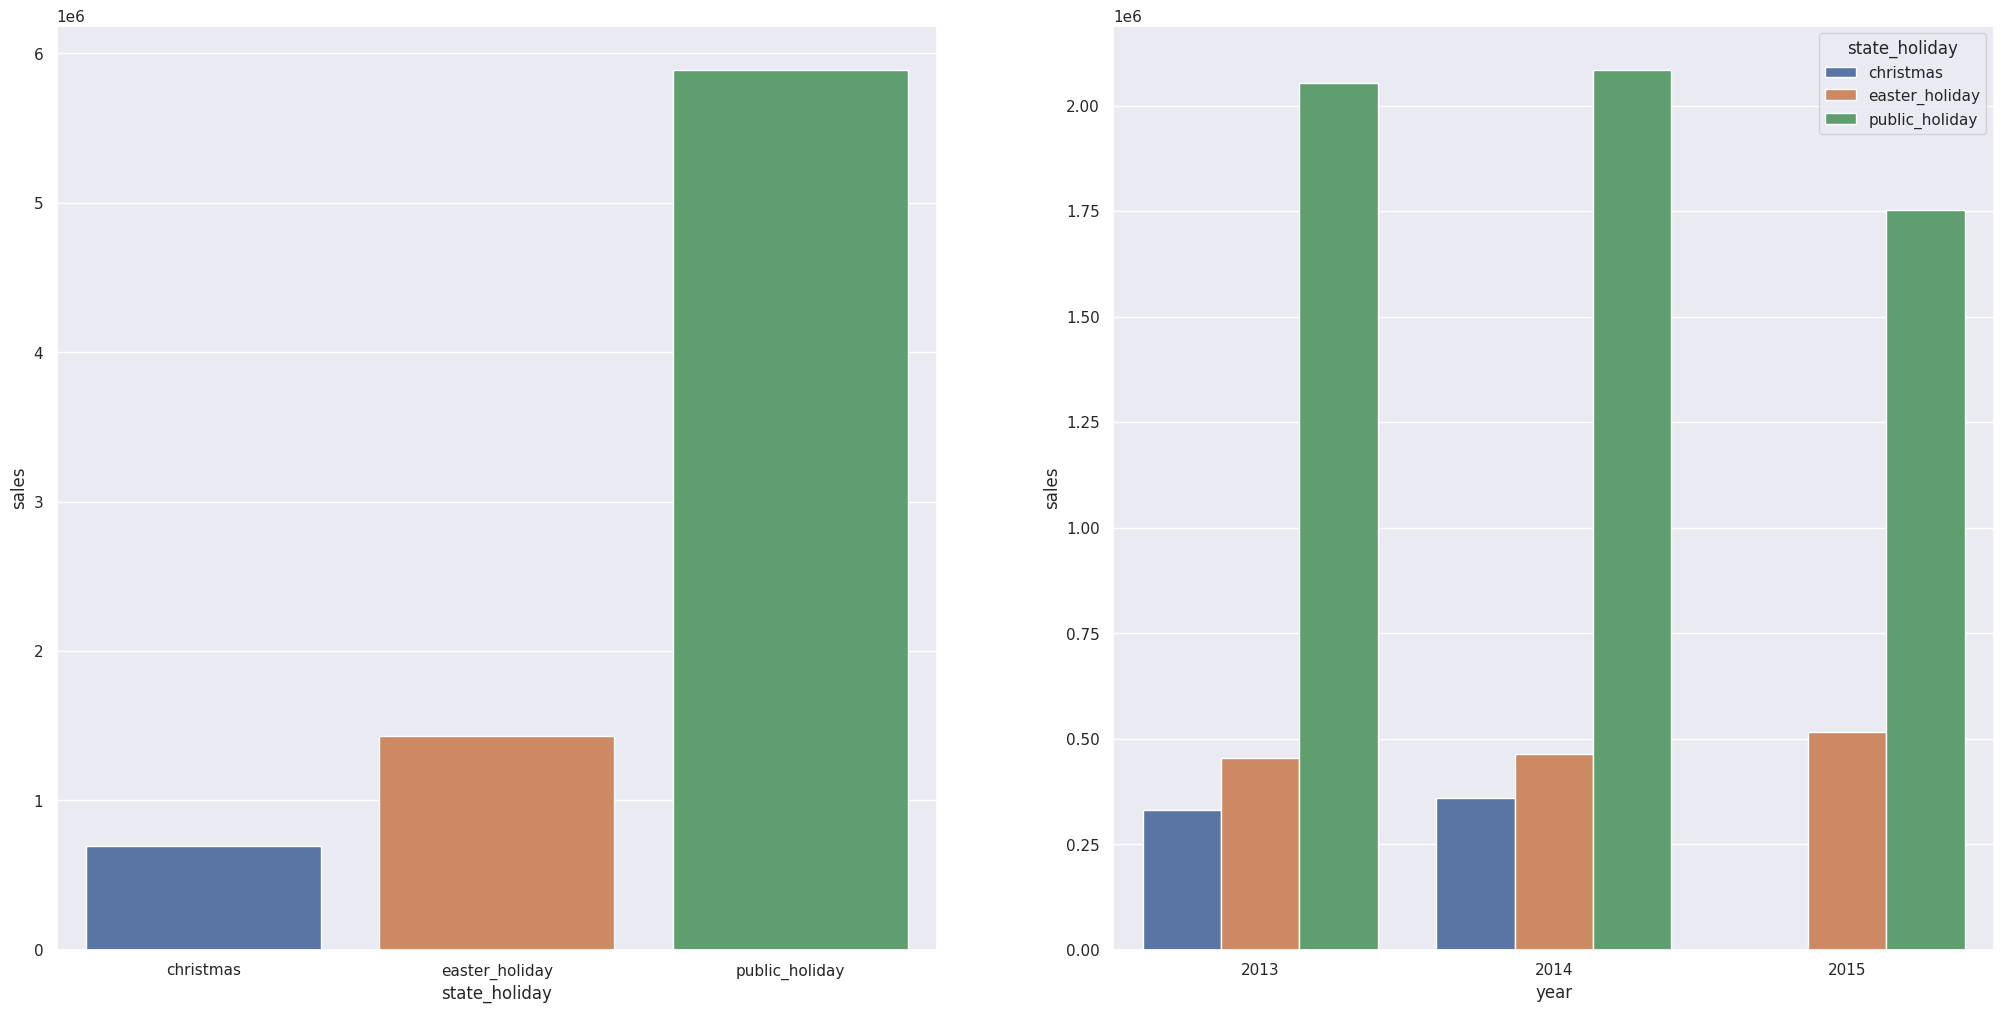

In [ ]:
aux = df4.loc[df4["state_holiday"] != "regular_day"]

plt.subplot(1, 2, 1)
aux1 = (
    aux.loc[:, ["state_holiday", "sales"]]
    .groupby(["state_holiday"])
    .sum()
    .reset_index()
)
sns.barplot(x="state_holiday", y="sales", data=aux1)

plt.subplot(1, 2, 2)
aux2 = (
    aux.loc[:, ["year", "state_holiday", "sales"]]
    .groupby(["year", "state_holiday"])
    .sum()
    .reset_index()
)
sns.barplot(x="year", y="sales", hue="state_holiday", data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.  
**FALSA** Lojas vendem menos ao longo dos anos

/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


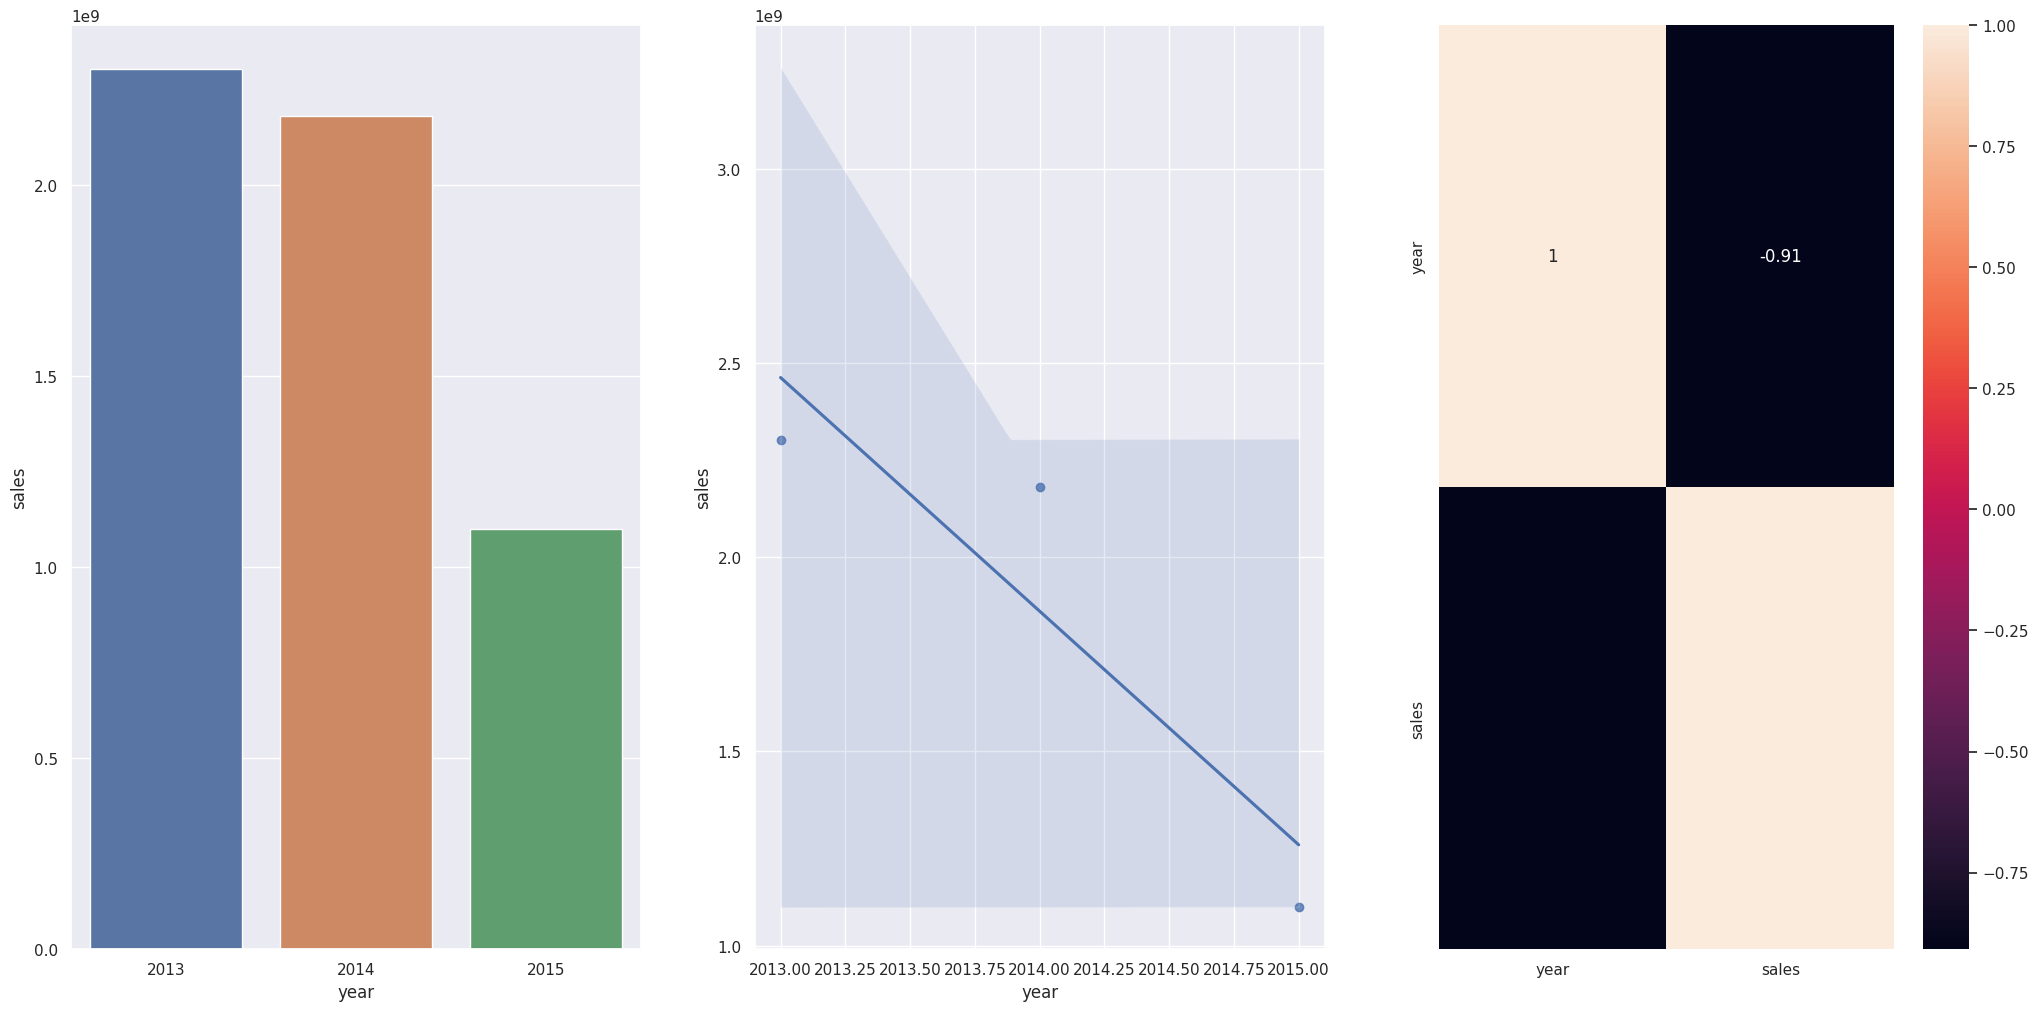

In [ ]:
aux1 = df4.loc[:, ["year", "sales"]].groupby(["year"]).sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x="year", y="sales", data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x="year", y="sales", data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

### **H9**. Lojas deveriam vender mais no segundo semestre do ano.  
**FALSA** Lojas vendem menos no segundo semestre do ano

/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


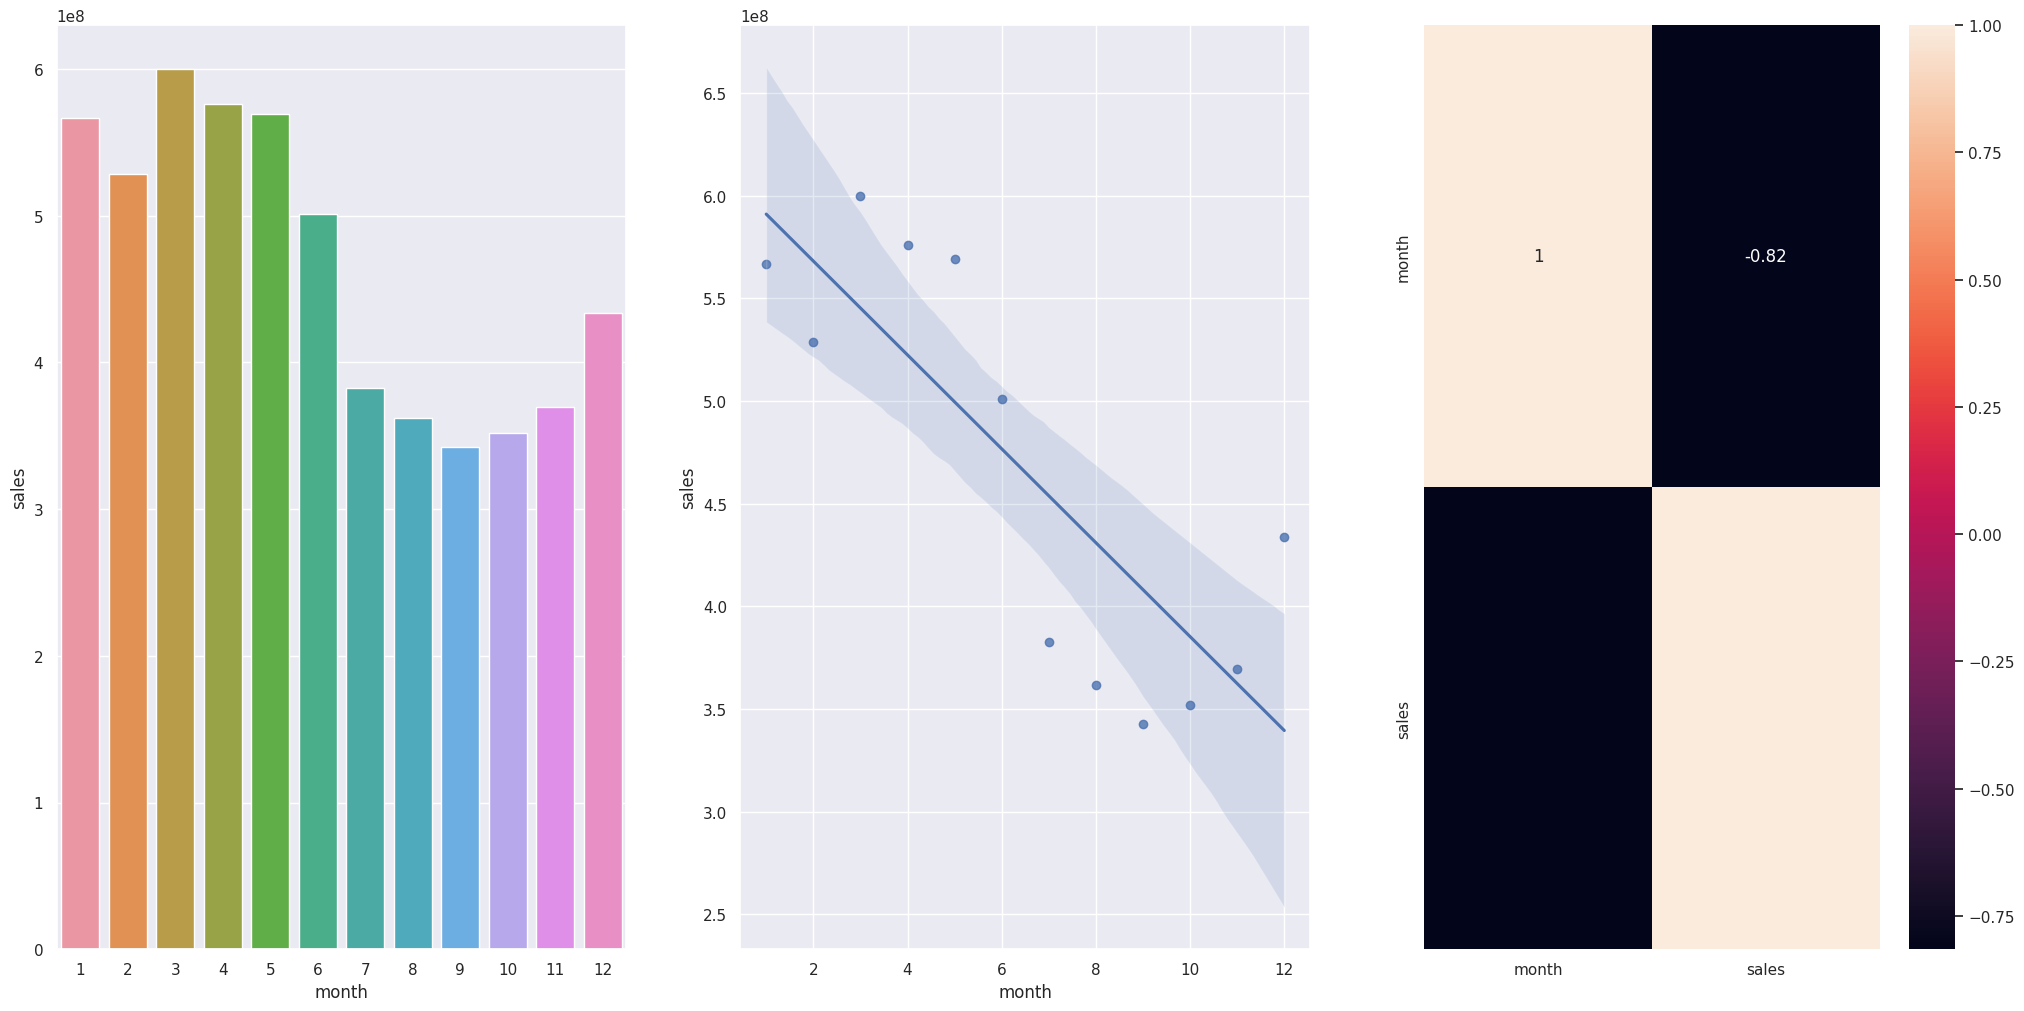

In [ ]:
aux1 = df4.loc[:, ["month", "sales"]].groupby(["month"]).sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x="month", y="sales", data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x="month", y="sales", data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

### **H10**. Lojas deveriam vender mais depois do dia 10 de cada mês.  
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarni

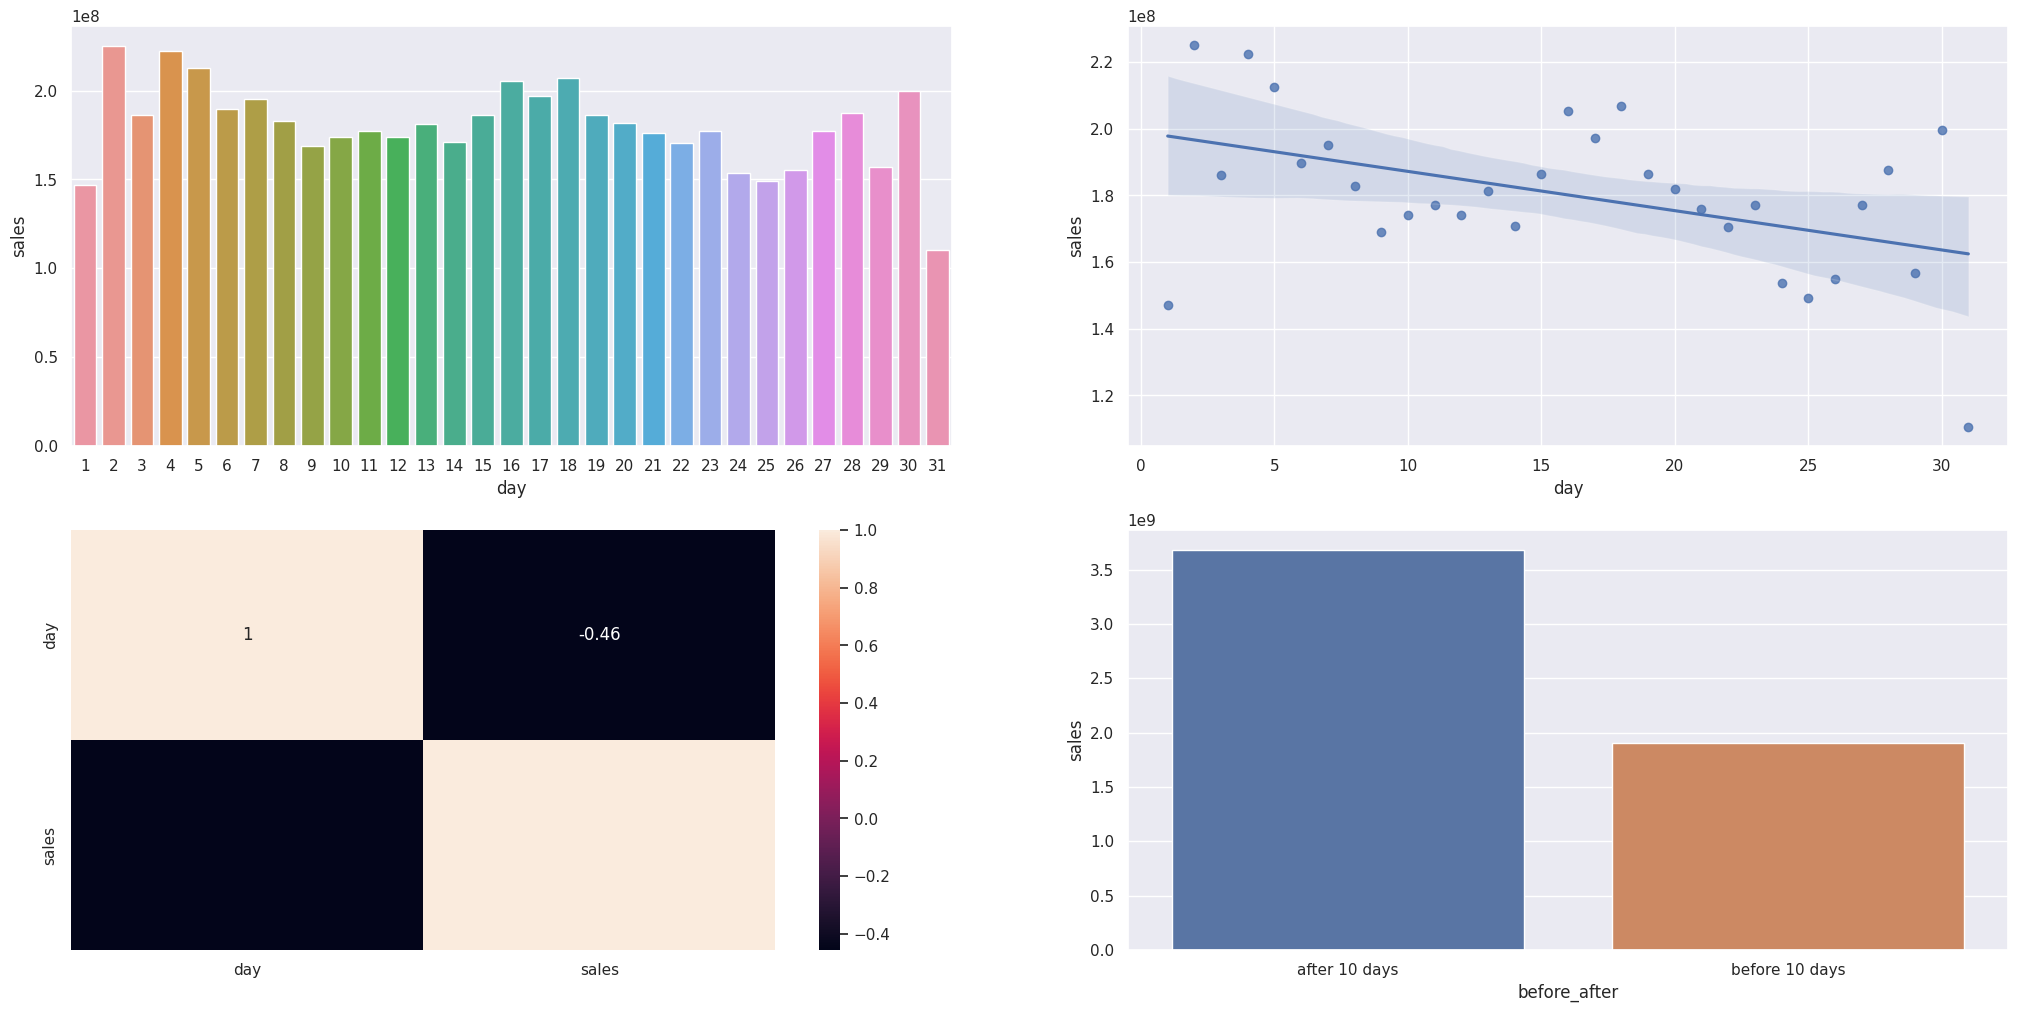

In [ ]:
aux1 = df4.loc[:, ["day", "sales"]].groupby(["day"]).sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x="day", y="sales", data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x="day", y="sales", data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

plt.subplot(2, 2, 4)
aux1["before_after"] = aux1["day"].apply(
    lambda x: "before 10 days" if x <= 10 else "after 10 days"
)
aux2 = (
    aux1.loc[:, ["before_after", "sales"]].groupby(["before_after"]).sum().reset_index()
)
sns.barplot(x="before_after", y="sales", data=aux2);

### **H11**. Lojas deveriam vender menos aos finais de semana.  
**VERDADEIRA** Lojas vendem menos nos final de semana

/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/producao_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


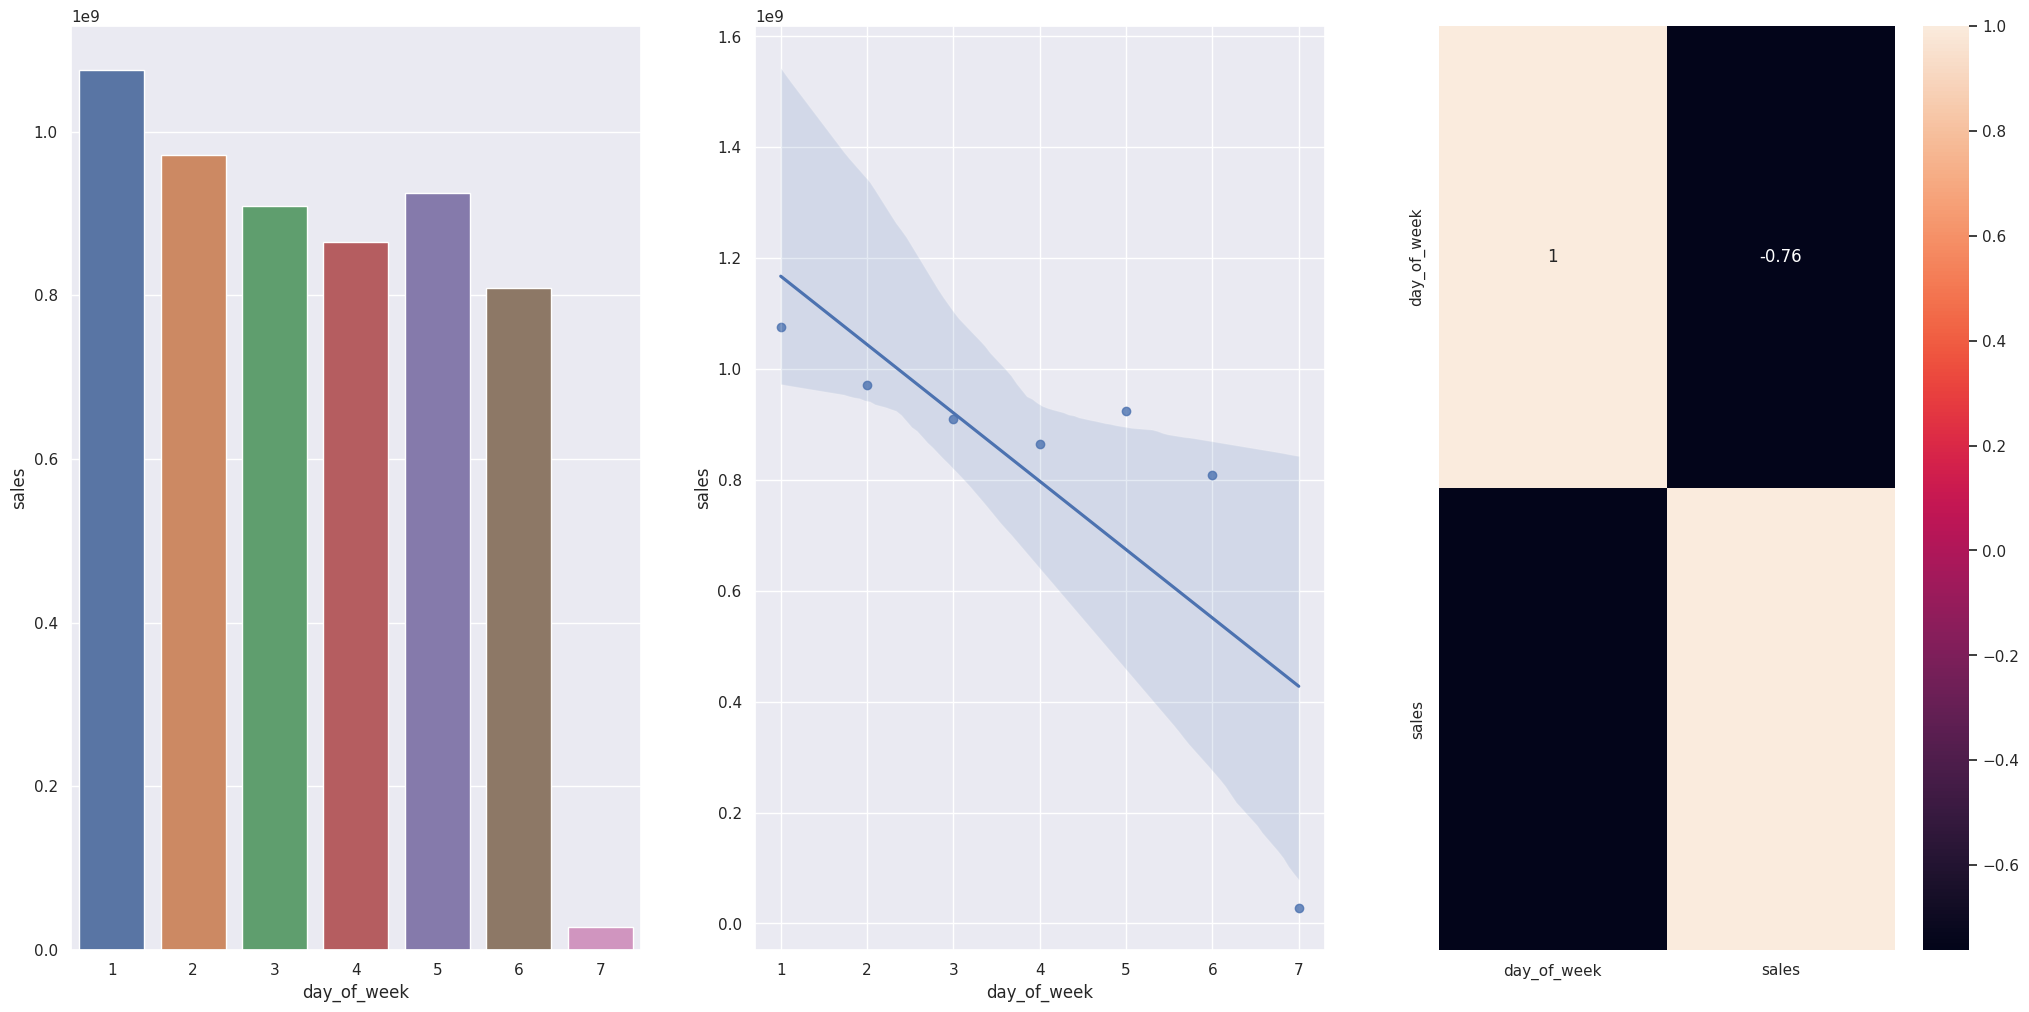

In [ ]:
aux1 = df4.loc[:, ["day_of_week", "sales"]].groupby(["day_of_week"]).sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x="day_of_week", y="sales", data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x="day_of_week", y="sales", data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

### **H12**. Lojas deveriam vender menos durante os feriados escolares.  
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

In [ ]:
aux1 = (
    df4.loc[:, ["school_holiday", "sales"]]
    .groupby(["school_holiday"])
    .sum()
    .reset_index()
)

plt.subplot(2, 1, 1)
sns.barplot(x="school_holiday", y="sales", data=aux1)

plt.subplot(2, 1, 2)
aux2 = (
    df4.loc[:, ["month", "school_holiday", "sales"]]
    .groupby(["month", "school_holiday"])
    .sum()
    .reset_index()
)
sns.barplot(x="month", y="sales", hue="school_holiday", data=aux2);

NameError: name 'df4' is not defined

### **Resumo das Hipóteses**

In [ ]:
tab = [
    ["Hipoteses", "Conclusao", "Relevancia"],
    ["H1", "Falsa", "Baixa"],
    ["H2", "Falsa", "Media"],
    ["H3", "Falsa", "Media"],
    ["H4", "Falsa", "Baixa"],
    ["H5", "-", "-"],
    ["H6", "Falsa", "Baixa"],
    ["H7", "Falsa", "Media"],
    ["H8", "Falsa", "Alta"],
    ["H9", "Falsa", "Alta"],
    ["H10", "Verdadeira", "Alta"],
    ["H11", "Verdadeira", "Alta"],
    ["H12", "Verdadeira", "Baixa"],
]
print(tabulate(tab, headers="firstrow"))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 - Análise Multivariada

## 4.3.1 - Atributos Numéricos

<Axes: >

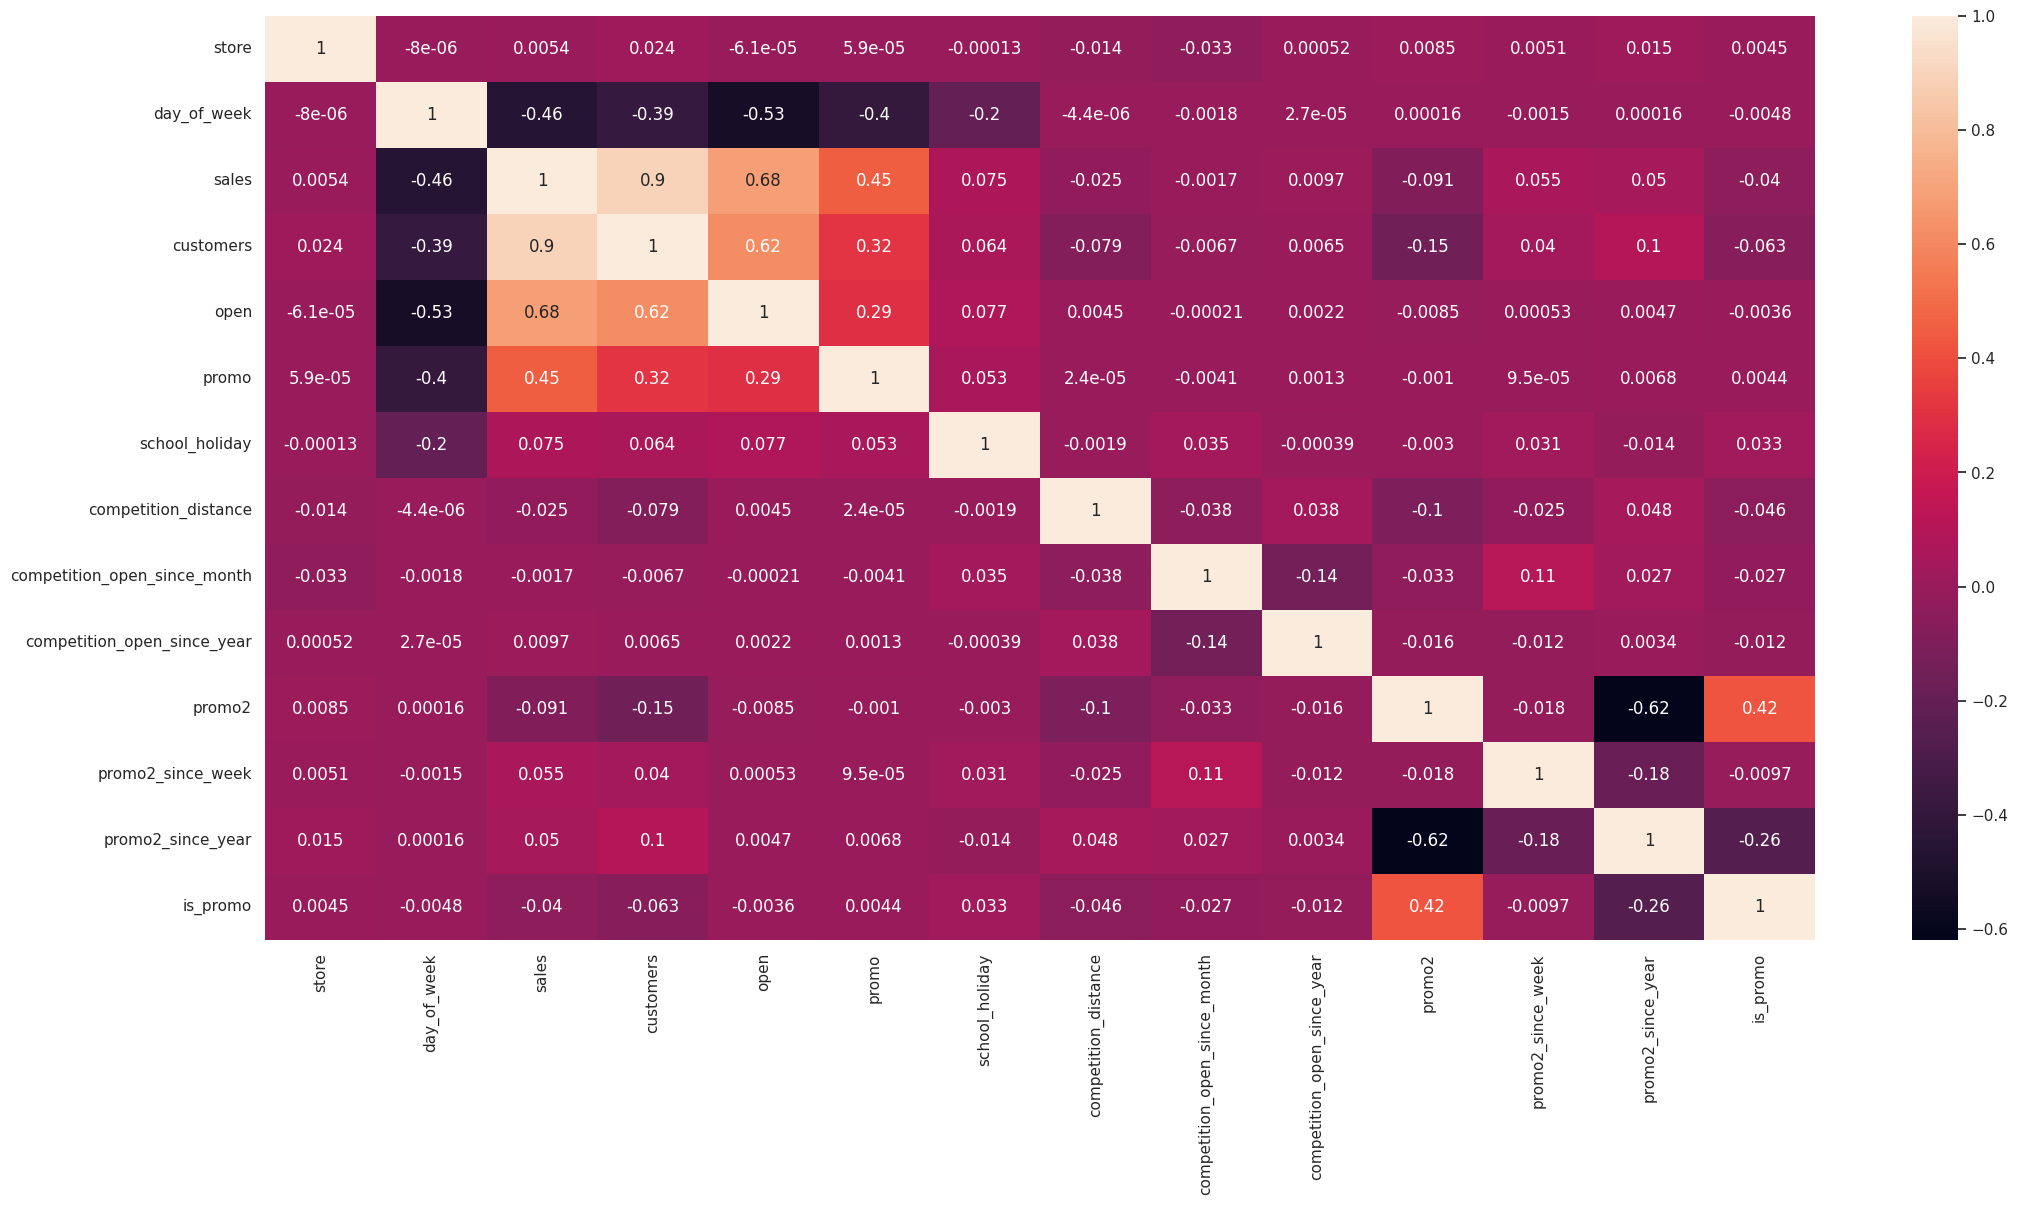

In [ ]:
correlation = num_attributes.corr(method="pearson")
sns.heatmap(correlation, annot=True)

## 4.3.2- Atributos Categóricos

In [ ]:
a = df4.select_dtypes(include="object")

In [ ]:
a.head()

,state_holiday,store_type,assortment,year_week
47945,regular_day,c,basic,2015-24
47946,regular_day,a,basic,2015-24
47947,regular_day,a,basic,2015-24
47948,regular_day,c,extended,2015-24
47949,regular_day,a,basic,2015-24


<Axes: >

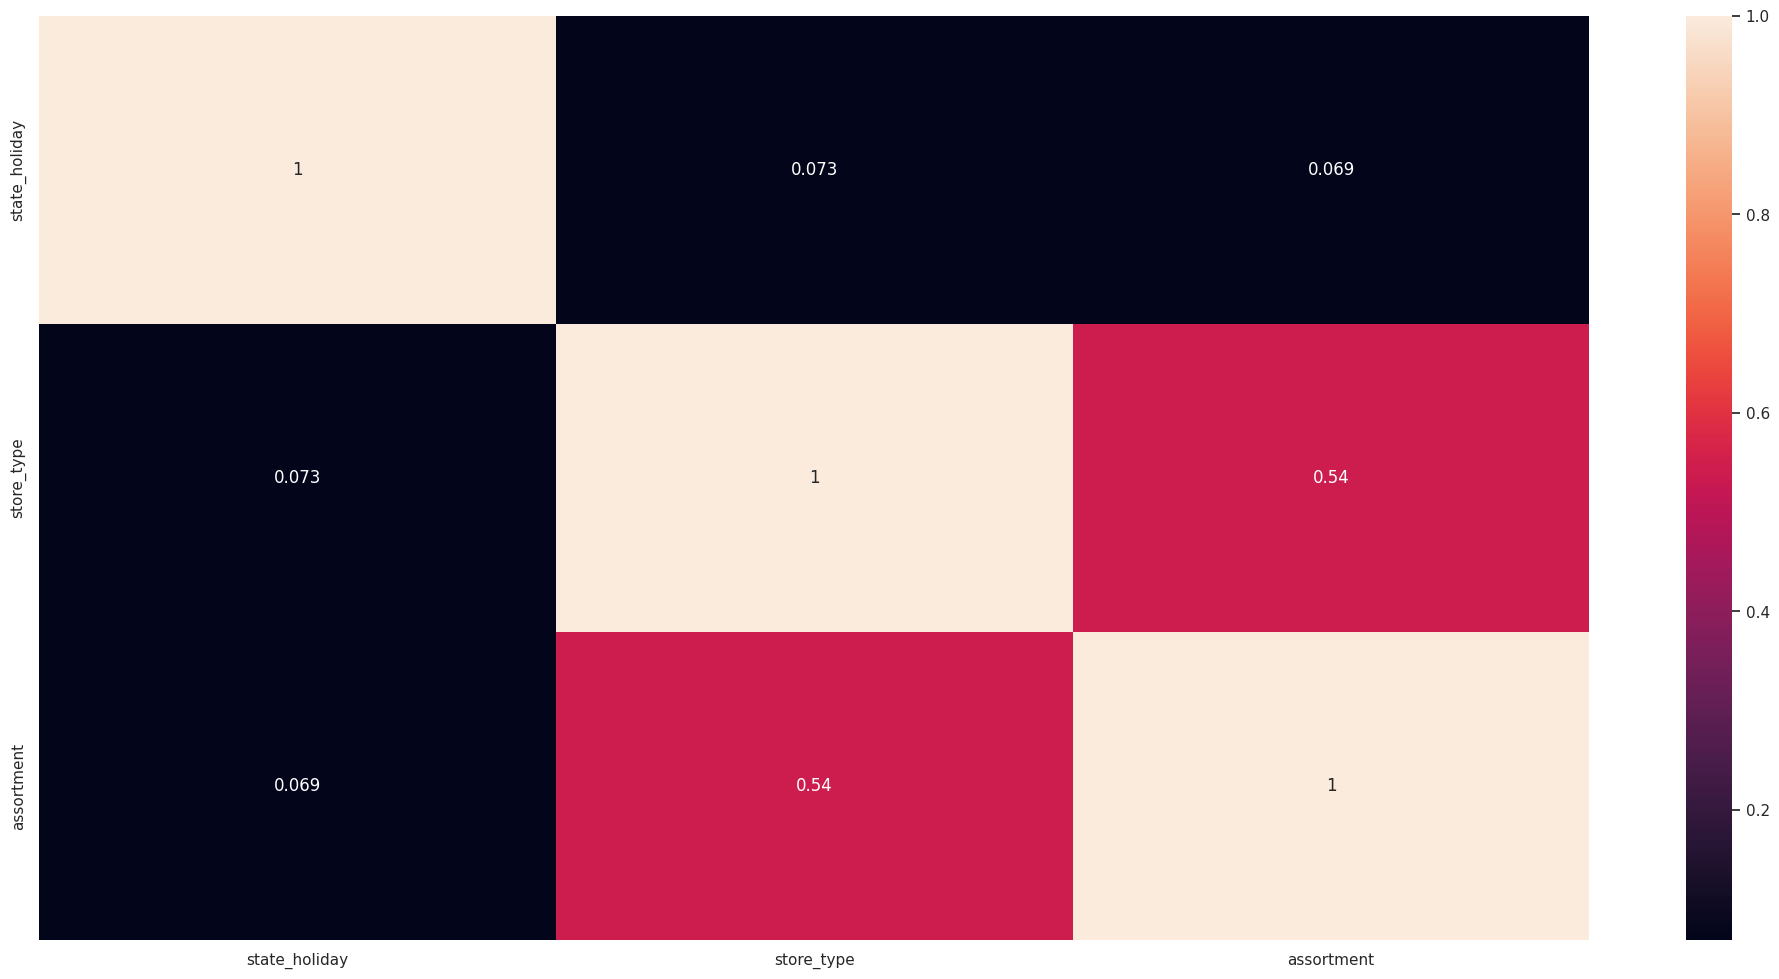

In [ ]:
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],'store_type': [a4, a5, a6], 'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0 - Preparação dos Dados

In [ ]:
df5 = df4.copy()

## 5.1 - Normalização

Não existem variáveis com distribuição normal, portanto a normalização dos dados não se aplica.  
Isso pode ser visualizado na análise univariada das categorias numéricas (Seção 4.1.2).

## 5.2 - Rescaling

In [ ]:
a = df5.select_dtypes(include=["int64", "float64"])

/home/elias/.pyenv/versions/3.11.4/envs/rossman_sales/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/rossman_sales/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='competition_time_month'>

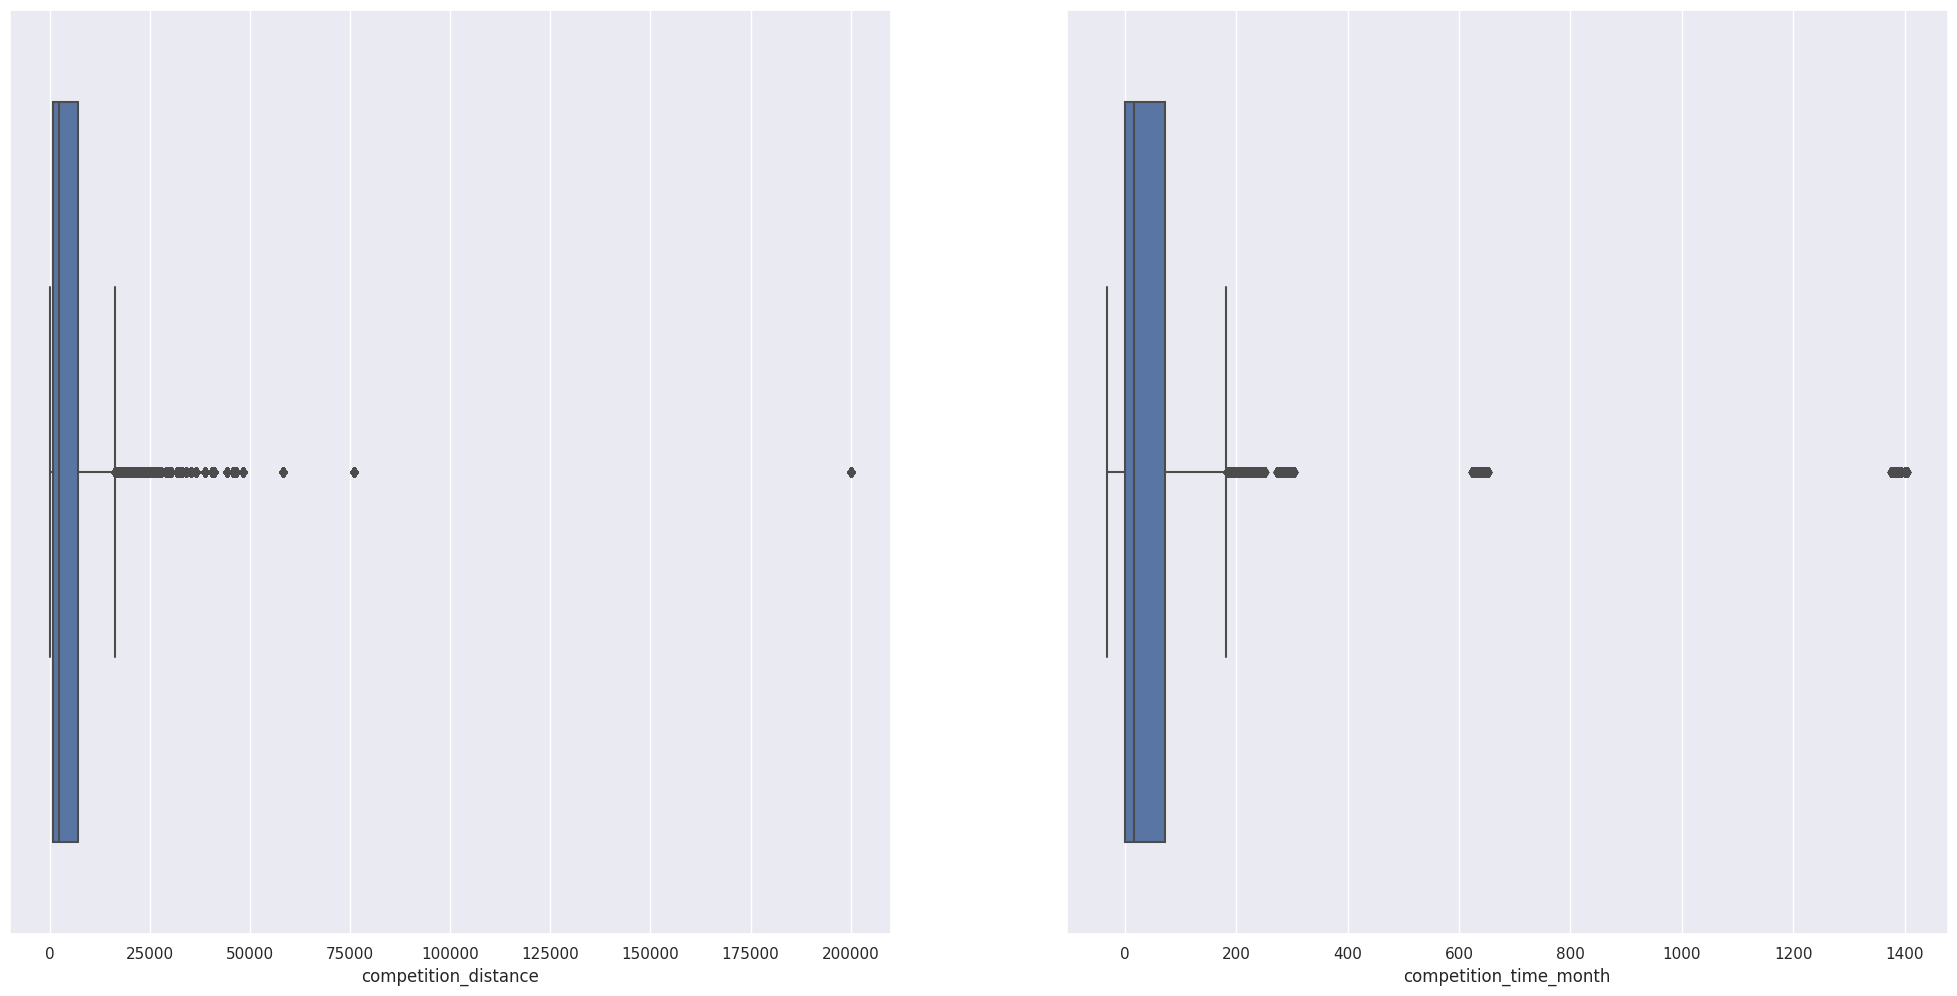

In [ ]:
plt.subplot(1, 2, 1)
sns.boxplot(x=a["competition_distance"])

plt.subplot(1, 2, 2)
sns.boxplot(x=a["competition_time_month"])

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5["competition_distance"] = rs.fit_transform(df5[["competition_distance"]].values)

# competition time month
df5["competition_time_month"] = rs.fit_transform(df5[["competition_time_month"]].values)

# promo time week
df5["promo_time_week"] = mms.fit_transform(df5[["promo_time_week"]].values)

# year
df5["year"] = mms.fit_transform(df5[["year"]].values)


## 5.3 - Transformação

### 5.3.1 - Encoding

In [ ]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
47945,1,4,2015-06-18,4645,1,regular_day,0,c,basic,-0.170968,9,2008,0,25,2015,0,1.0,6,18,25,2015-24,2008-09-01,0.904110,2015-06-15,0.290993
47946,2,4,2015-06-18,5154,1,regular_day,0,a,basic,-0.283871,11,2007,1,13,2010,0,1.0,6,18,25,2015-24,2007-11-01,1.041096,2010-03-22,0.921478
47947,3,4,2015-06-18,7537,1,regular_day,0,a,basic,1.903226,12,2006,1,14,2011,0,1.0,6,18,25,2015-24,2006-12-01,1.205479,2011-03-28,0.799076
47948,4,4,2015-06-18,8880,1,regular_day,0,c,extended,-0.275806,9,2009,0,25,2015,0,1.0,6,18,25,2015-24,2009-09-01,0.739726,2015-06-15,0.290993
47949,5,4,2015-06-18,4924,1,regular_day,0,a,basic,4.448387,4,2015,0,25,2015,0,1.0,6,18,25,2015-24,2015-04-01,-0.191781,2015-06-15,0.290993


In [ ]:
#state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=["state_holiday"], columns=["state_holiday"])

In [ ]:
# store type - Label Encoder
le = LabelEncoder()
df5["store_type"] = le.fit_transform(df5["store_type"])

In [ ]:
# assortment
assortment_dict = {
    "basic" : 1,
    "extra" : 2,
    "extended" : 3,
}

df5["assortment"] = df5["assortment"].map(assortment_dict)

In [ ]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
47945,1,4,2015-06-18,4645,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,6,18,25,2015-24,2008-09-01,0.904110,2015-06-15,0.290993,False,False,False,True
47946,2,4,2015-06-18,5154,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,6,18,25,2015-24,2007-11-01,1.041096,2010-03-22,0.921478,False,False,False,True
47947,3,4,2015-06-18,7537,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,6,18,25,2015-24,2006-12-01,1.205479,2011-03-28,0.799076,False,False,False,True
47948,4,4,2015-06-18,8880,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,6,18,25,2015-24,2009-09-01,0.739726,2015-06-15,0.290993,False,False,False,True
47949,5,4,2015-06-18,4924,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,6,18,25,2015-24,2015-04-01,-0.191781,2015-06-15,0.290993,False,False,False,True


### 5.3.2 - Response Variable Transformation

In [ ]:
df5["sales"] = np.log1p(df5["sales"])

/home/elias/.pyenv/versions/3.11.4/envs/rossman_sales/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/elias/.pyenv/versions/3.11.4/envs/rossman_sales/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='sales', ylabel='Count'>

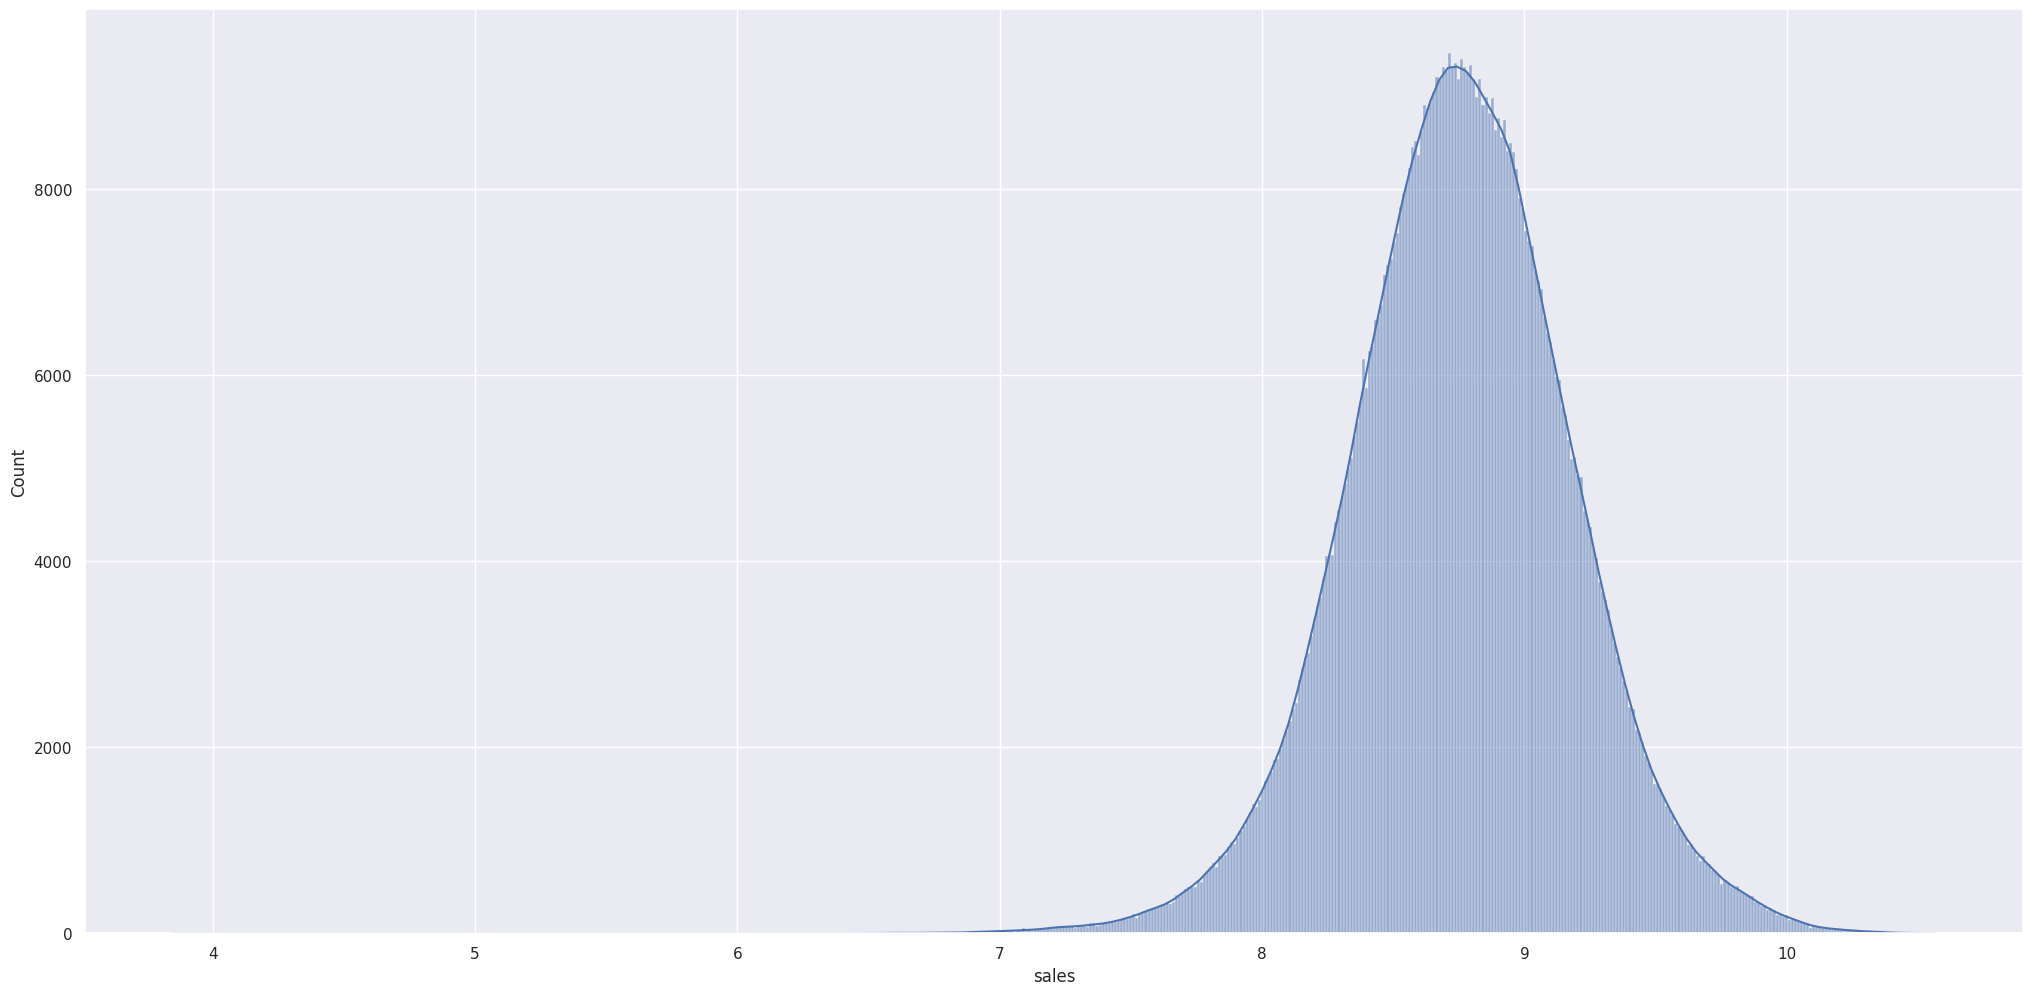

In [ ]:
sns.histplot(df5["sales"], kde=True)

### 5.3.3 - Natural Transformation

In [ ]:
# month
df5["month_sin"] = df5["month"].apply(lambda x: np.sin(x*(2. * np.pi/12)))
df5["month_cos"] = df5["month"].apply(lambda x: np.cos(x*(2. * np.pi/12)))

# day
df5["day_sin"] = df5["day"].apply(lambda x: np.sin(x*(2. * np.pi/30)))
df5["day_cos"] = df5["day"].apply(lambda x: np.cos(x*(2. * np.pi/30)))

# day of week
df5["day_of_week_sin"] = df5["day_of_week"].apply(lambda x: np.sin(x*(2. * np.pi/7)))
df5["day_of_week_cos"] = df5["day_of_week"].apply(lambda x: np.cos(x*(2. * np.pi/7)))

# week of year
df5["week_of_year_sin"] = df5["week_of_year"].apply(lambda x: np.sin(x*(2. * np.pi/52)))
df5["week_of_year_cos"] = df5["week_of_year"].apply(lambda x: np.cos(x*(2. * np.pi/52)))

# 6.0 - Feature Selection

In [ ]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
47945,1,4,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,6,18,25,2015-24,2008-09-01,0.904110,2015-06-15,0.290993,False,False,False,True,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709
47946,2,4,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,6,18,25,2015-24,2007-11-01,1.041096,2010-03-22,0.921478,False,False,False,True,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709
47947,3,4,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,6,18,25,2015-24,2006-12-01,1.205479,2011-03-28,0.799076,False,False,False,True,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709
47948,4,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,6,18,25,2015-24,2009-09-01,0.739726,2015-06-15,0.290993,False,False,False,True,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709
47949,5,4,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,6,18,25,2015-24,2015-04-01,-0.191781,2015-06-15,0.290993,False,False,False,True,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709


In [ ]:
df6 = df5.copy()

cols_drop = ["day_of_week", "day", "month", "week_of_year", "promo_since", "competition_since", "year_week"]

df6 = df6.drop(cols_drop, axis=1)

df6.columns

Index(['store', 'date', 'sales', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'competition_time_month',
       'promo_time_week', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

: 

## 6.1 - Split Dataset

In [ ]:
X_train = df6.copy()
y_train = X_train['sales']

## 6.2 - Boruta Selection

In [ ]:
# Train and Test datasets for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# Define RandonForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# Define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 - Best Features From Boruta

In [ ]:
cols_selected = boruta.support_.to_list()

# Best Features 
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Features Not Selected
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

NameError: name 'boruta' is not defined

In [ ]:
cols_selected_boruta

In [ ]:
cols_not_selected_boruta